# Predicting the Number of Half-Pint Equivalents of Alcoholic Beverages Consumed Per Day Using a Machine Learning Model Approach

##1.Project Overview

This project aims to develop a machine learning model to predict the number of half-pint equivalents of alcoholic beverages consumed per day by individuals, based on specific blood test results. The dataset is derived from the BUPA Medical Research Ltd. database, containing various blood tests considered sensitive to liver disorders that could be caused by excessive alcohol consumption. The objective is to leverage regression techniques to predict alcohol consumption levels and identify patterns in the blood test indicators that might correlate with different consumption rates.


##2.Data Information

https://archive.ics.uci.edu/dataset/60/liver+disorders


| Variable Name | Role     | Type        | Description                                           | Units           | Missing Values |
|---------------|----------|-------------|-------------------------------------------------------|-----------------|----------------|
| mcv           | Feature  | Continuous  | Mean corpuscular volume                                | -               | No             |
| alkphos       | Feature  | Continuous  | Alkaline phosphatase                                   | -               | No             |
| sgpt          | Feature  | Continuous  | Alanine aminotransferase                               | -               | No             |
| sgot          | Feature  | Continuous  | Aspartate aminotransferase                             | -               | No             |
| gammagt       | Feature  | Continuous  | Gamma-glutamyl transpeptidase                          | -               | No             |
| drinks        | Target   | Continuous  | Number of half-pint equivalents of alcoholic beverages drunk per day | -               | No             |
| selector      | Other    | Categorical | Field created by BUPA researchers to split data into train/test sets | -               | No             |


##3.Data Inspecting and Preprocessing

In [79]:
!pip install catboost

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [81]:
pip install ucimlrepo

In [82]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
liver_disorders = fetch_ucirepo(id=60)

# data (as pandas dataframes)
X = liver_disorders.data.features
y = liver_disorders.data.targets

# metadata
print(liver_disorders.metadata)

# variable information
print(liver_disorders.variables)

{'uci_id': 60, 'name': 'Liver Disorders', 'repository_url': 'https://archive.ics.uci.edu/dataset/60/liver+disorders', 'data_url': 'https://archive.ics.uci.edu/static/public/60/data.csv', 'abstract': 'BUPA Medical Research Ltd. database donated by Richard S. Forsyth', 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 345, 'num_features': 5, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['drinks'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C54G67', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'The first 5 variables are all blood tests which are thought to be sensitive to liver disorders that might arise from excessive alcohol consumption. Each line in the dataset constitutes the record of a single male individual.\n\nImportant note: The 7

In [83]:
# Concatenates X and y into the DataFrames
df = pd.concat([X, y], axis=1)

# Display the first few rows of the combined DataFrame
df.head()

,mcv,alkphos,sgpt,sgot,gammagt,drinks
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0


In [84]:
# Check its rows and columns
df.shape

(345, 6)

In [85]:
# Check its information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mcv      345 non-null    int64  
 1   alkphos  345 non-null    int64  
 2   sgpt     345 non-null    int64  
 3   sgot     345 non-null    int64  
 4   gammagt  345 non-null    int64  
 5   drinks   345 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 16.3 KB


In [86]:
# Check its missing values
df.isnull().sum()

,0
mcv,0
alkphos,0
sgpt,0
sgot,0
gammagt,0
drinks,0


In [87]:
# Check its duplication
df.duplicated().sum()

4

In [88]:
df.describe()

,mcv,alkphos,sgpt,sgot,gammagt,drinks
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,90.159420,69.869565,30.405797,24.643478,38.284058,3.455072
std,4.448096,18.347670,19.512309,10.064494,39.254616,3.337835
min,65.000000,23.000000,4.000000,5.000000,5.000000,0.000000
25%,87.000000,57.000000,19.000000,19.000000,15.000000,0.500000
50%,90.000000,67.000000,26.000000,23.000000,25.000000,3.000000
75%,93.000000,80.000000,34.000000,27.000000,46.000000,6.000000
max,103.000000,138.000000,155.000000,82.000000,297.000000,20.000000


In [89]:
df.dtypes

,0
mcv,int64
alkphos,int64
sgpt,int64
sgot,int64
gammagt,int64
drinks,float64


##4.Exploratory Data Analysis (EDA)

###Correlation Heatmap

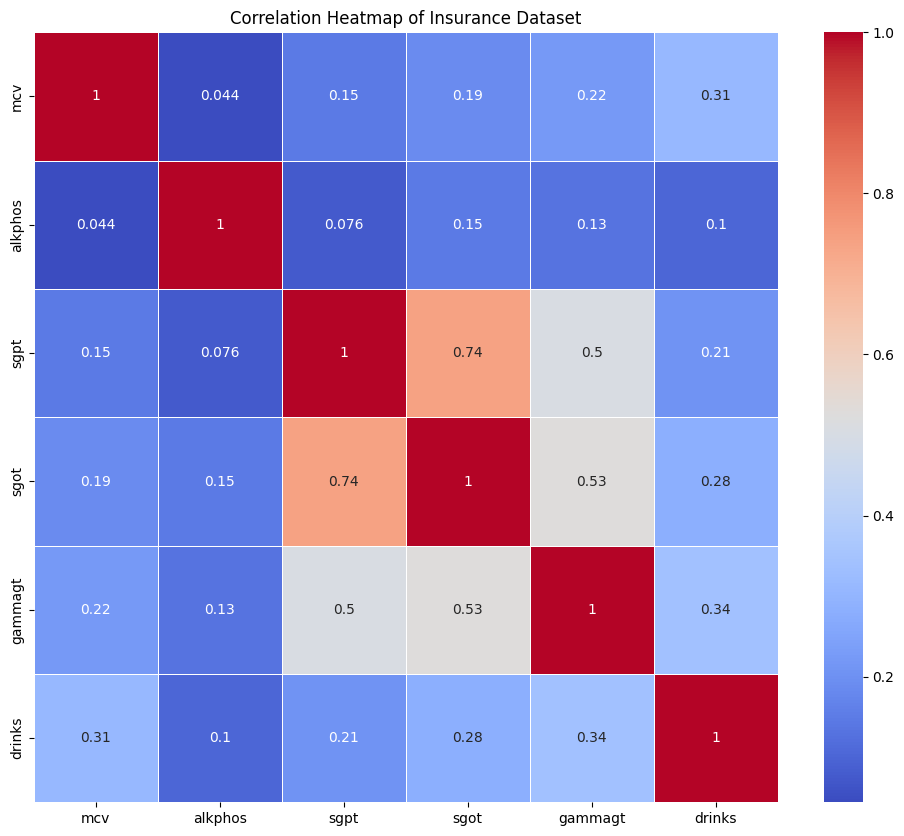

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Insurance Dataset")
plt.show()

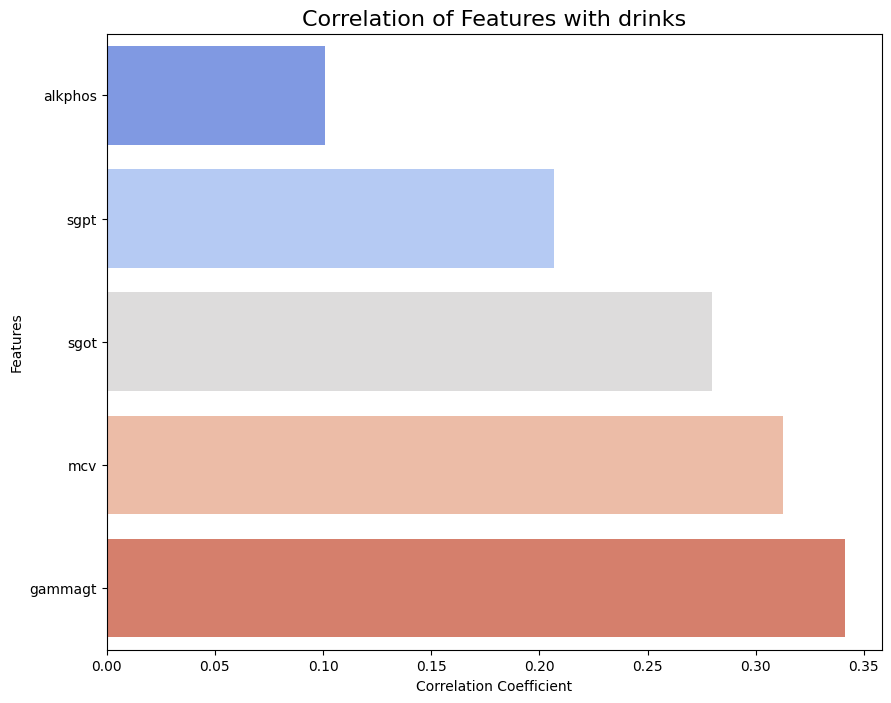

In [91]:
# Calculate the correlation of each feature with the target variable 'drinks'
correlations = df.corr()['drinks'].drop('drinks').sort_values()

# Plotting the horizontal bar chart for correlations with 'drinks'
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation of Features with drinks', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

###Pairplot

In [92]:
df.columns

Index(['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks'], dtype='object')

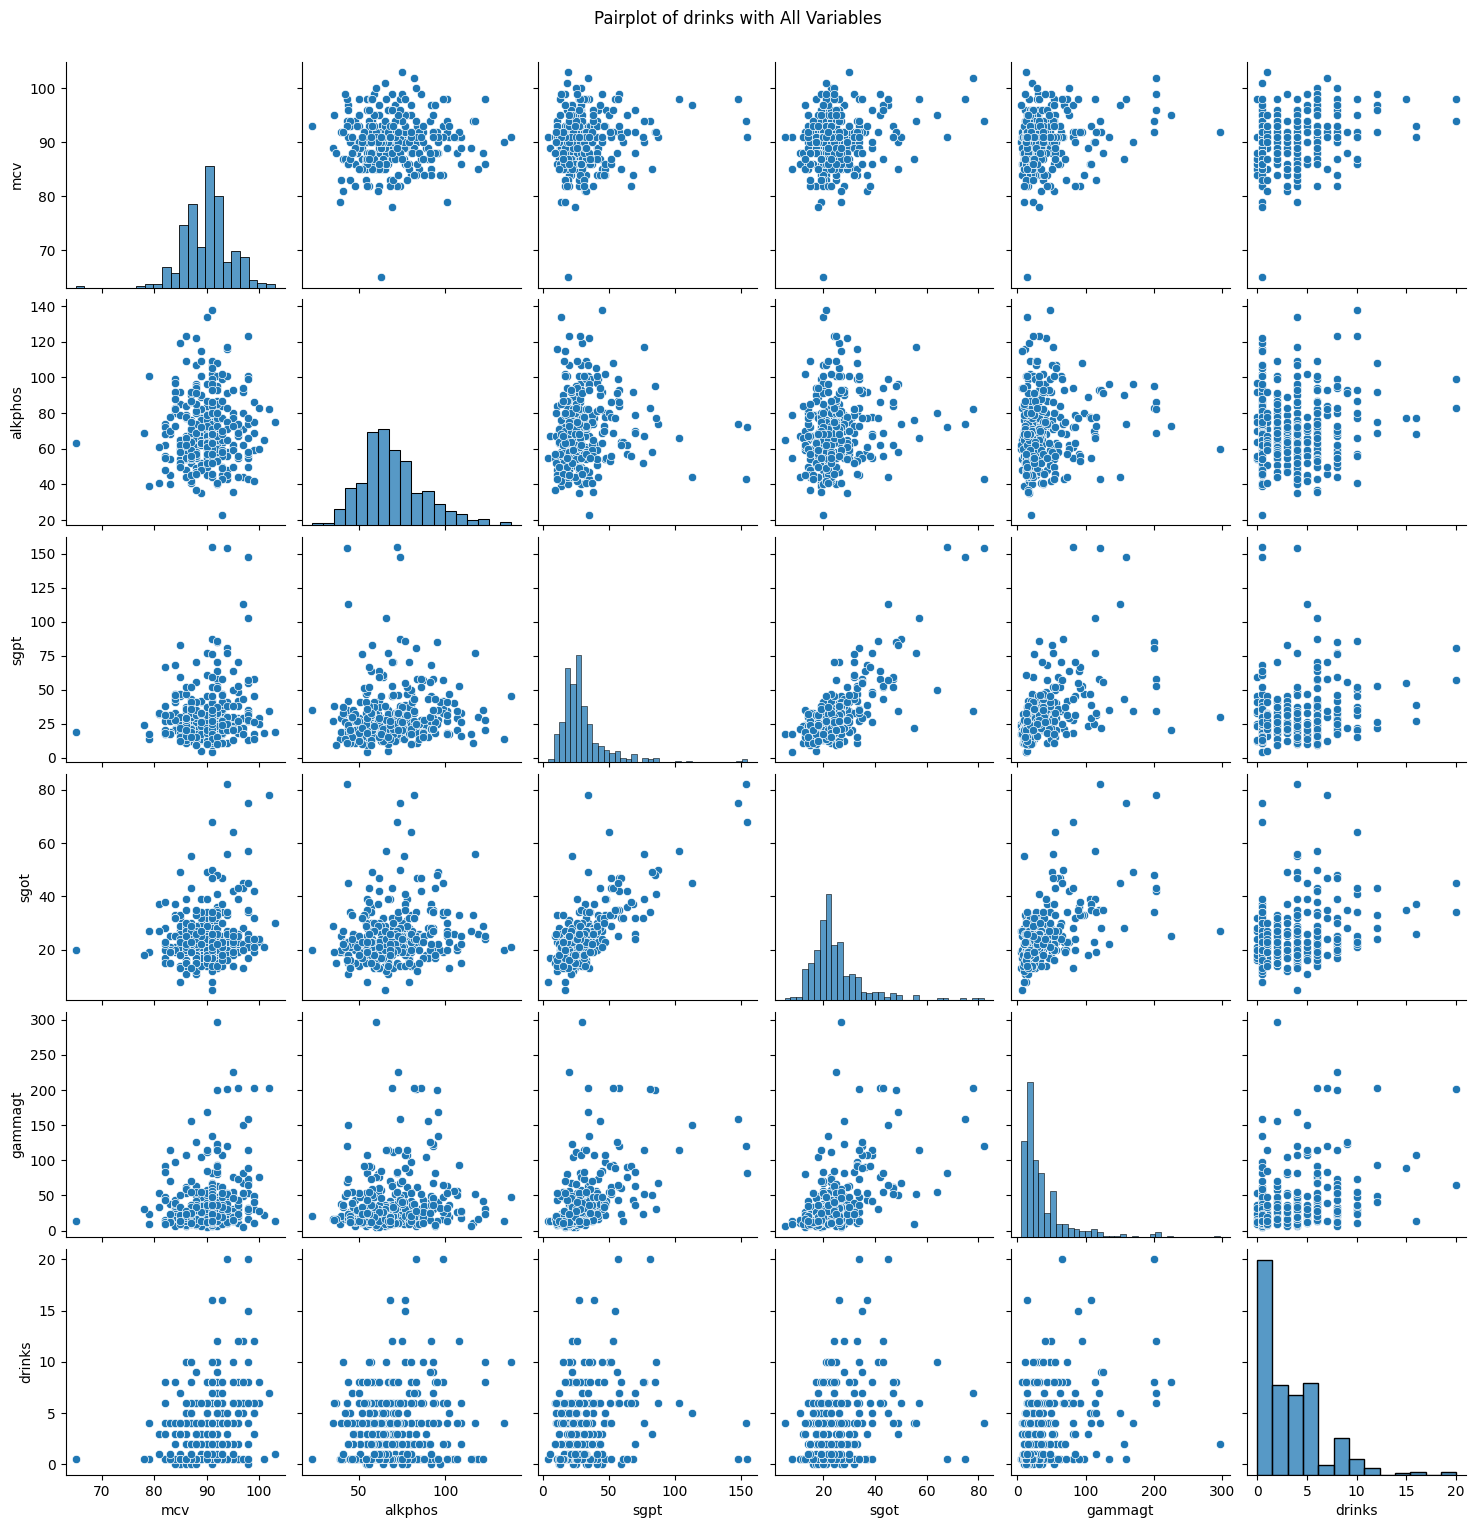

In [93]:
# Pairplot of age with all variables
pairplot = sns.pairplot(df, vars=['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks'])
pairplot.fig.suptitle('Pairplot of drinks with All Variables', y=1.02)  # y=1.02 adjusts the title position
plt.show()

###Checking for Multicollinearity Using Variance Inflation Factor (VIF)

In [94]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only the relevant features
X = df[['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   Feature        VIF
0      mcv  19.586330
1  alkphos  15.598094
2     sgpt   7.926689
3     sgot  16.967641
4  gammagt   2.813239


* VIF = 1: No multicollinearity.
* 1 < VIF < 5: Moderate multicollinearity.
* VIF > 5: High multicollinearity (potentially problematic).
* VIF > 10: Strong multicollinearity; you might consider removing or combining these features.

The VIF values for **mcv**, **alkphos**, and **sgot** are significantly above 10, indicating strong multicollinearity. This suggests that these features are highly correlated with each other or with a combination of other features.

High multicollinearity can make the model coefficients unstable and unreliable, as small changes in the data can lead to large changes in the estimated coefficients.

The VIF value for **sgpt** is around 7.93, which is moderate to high. While it is less problematic than the others, it may still contribute to multicollinearity.

The VIF for **gammagt** is 2.81, indicating low multicollinearity. This feature does not pose a significant multicollinearity problem and can be retained in the model.

###drinks (Target Variable)

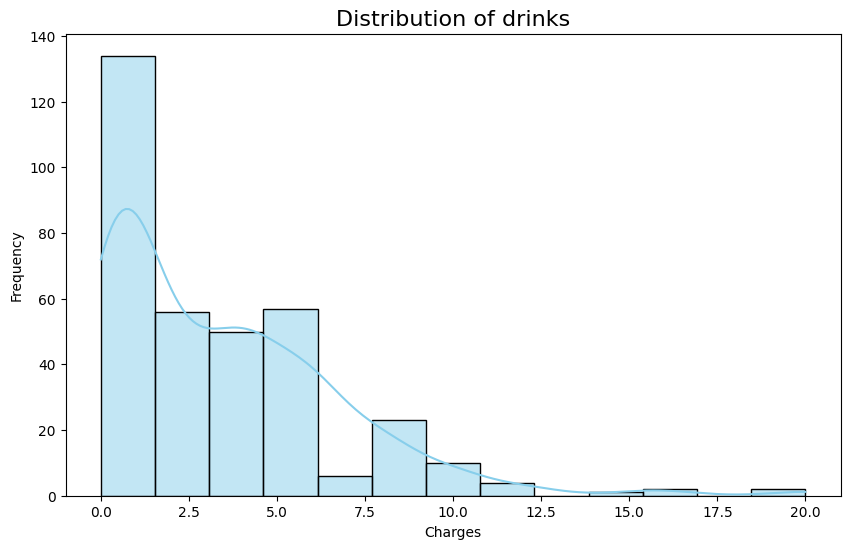

In [95]:
# Histogram of charges
plt.figure(figsize=(10, 6))
sns.histplot(df['drinks'], kde=True, color='skyblue')
plt.title('Distribution of drinks', fontsize=16)
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

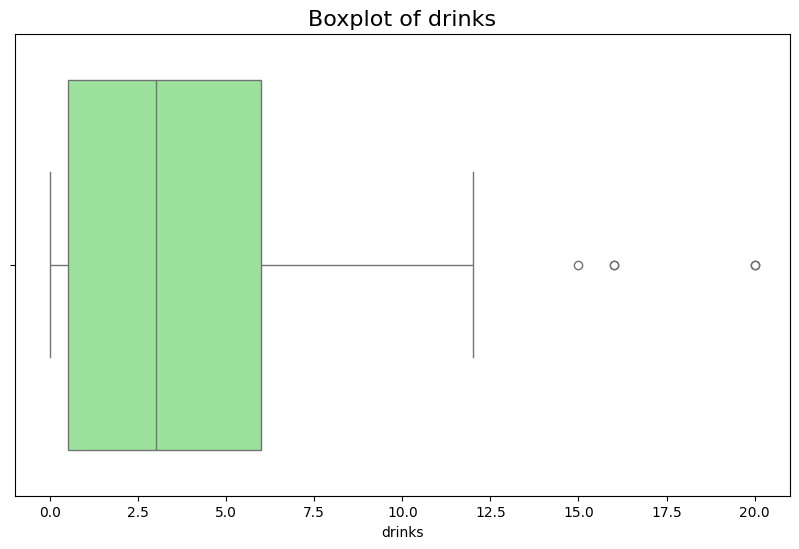

In [96]:
# Boxplot of drinks
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['drinks'], color='lightgreen')
plt.title('Boxplot of drinks', fontsize=16)
plt.xlabel('drinks')
plt.show()

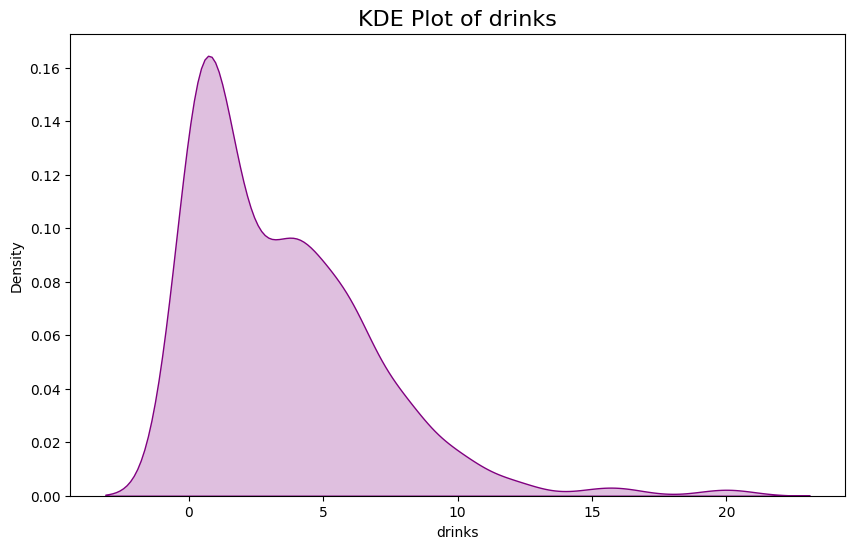

In [97]:
# KDE plot of drinks
plt.figure(figsize=(10, 6))
sns.kdeplot(df['drinks'], shade=True, color='purple')
plt.title('KDE Plot of drinks', fontsize=16)
plt.xlabel('drinks')
plt.ylabel('Density')
plt.show()

In [98]:
df.columns

Index(['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks'], dtype='object')

####Log Transformation

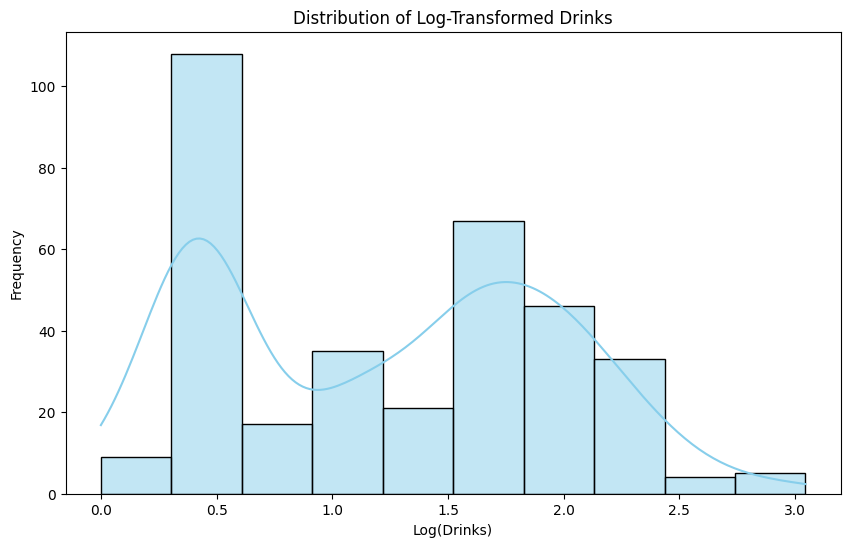

In [99]:
# Apply log transformation to 'drinks' column
df['drinks_log'] = np.log1p(df['drinks'])  # Log transformation

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['drinks_log'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed Drinks')
plt.xlabel('Log(Drinks)')
plt.ylabel('Frequency')
plt.show()

####Square Root Transformation

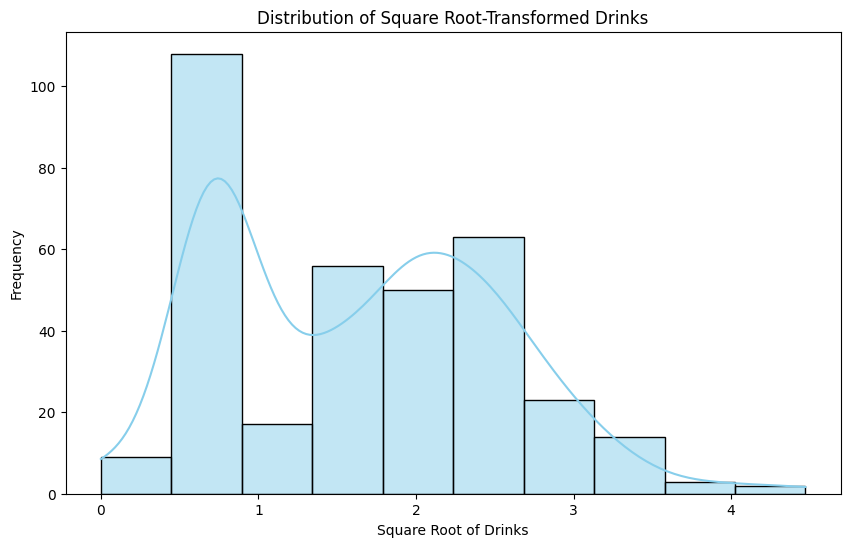

In [100]:
# Apply square root transformation to the 'drinks' column
df['drinks_sqrt'] = np.sqrt(df['drinks'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['drinks_sqrt'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Square Root-Transformed Drinks')
plt.xlabel('Square Root of Drinks')
plt.ylabel('Frequency')
plt.show()

####Box-Cox Transformation

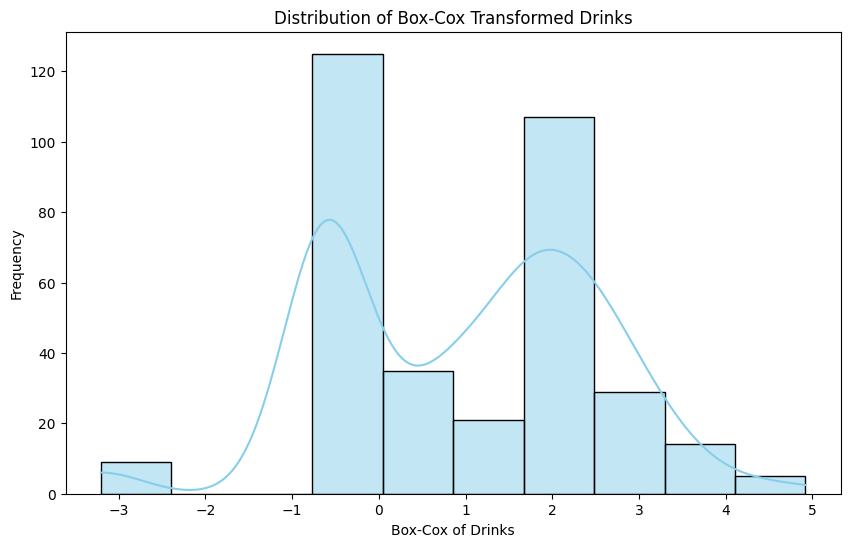

In [101]:
from scipy.stats import boxcox
# Ensure all values are positive (if necessary)
df['drinks'] = df['drinks'] + 1e-6  # Add a small constant to handle zero values

# Apply Box-Cox transformation
df['drinks_boxcox'], _ = boxcox(df['drinks'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['drinks_boxcox'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Box-Cox Transformed Drinks')
plt.xlabel('Box-Cox of Drinks')
plt.ylabel('Frequency')
plt.show()

####Yeo-Johnson Transformation

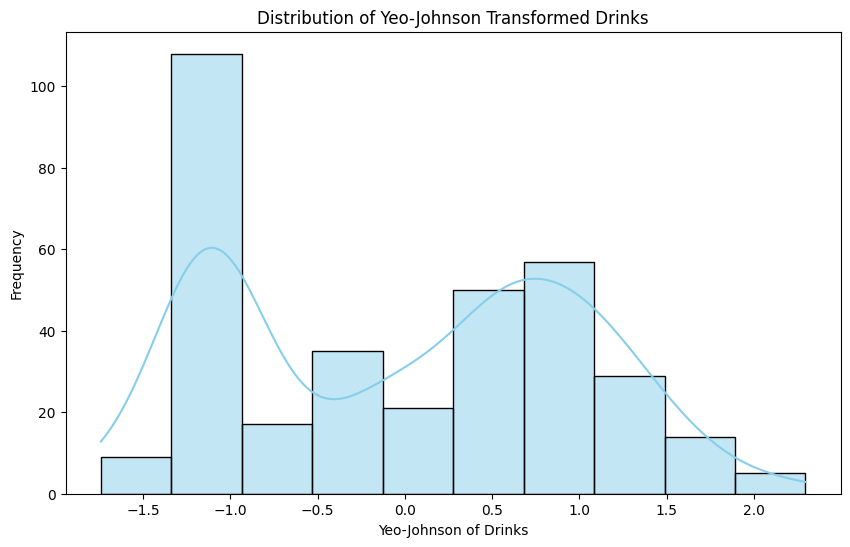

In [102]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['drinks_yeojohnson'] = pt.fit_transform(df[['drinks']])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['drinks_yeojohnson'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Yeo-Johnson Transformed Drinks')
plt.xlabel('Yeo-Johnson of Drinks')
plt.ylabel('Frequency')
plt.show()

###mcv

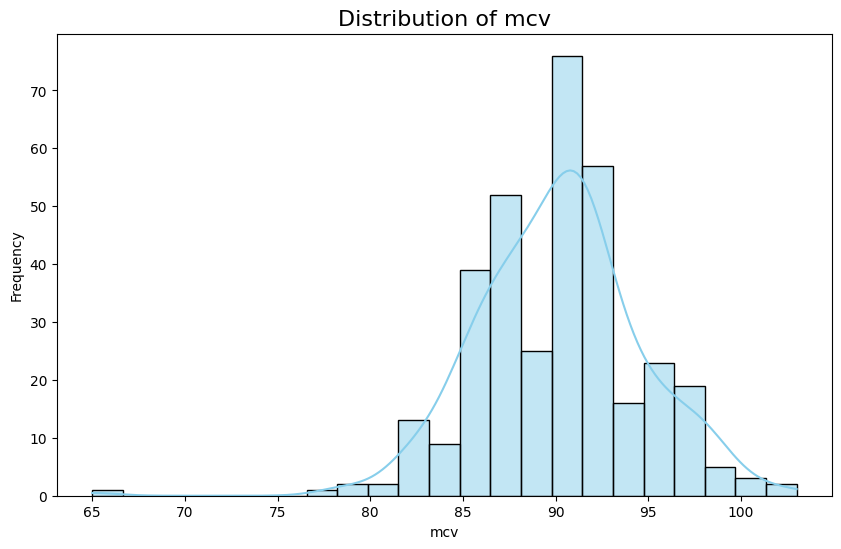

In [103]:
# Histogram of mcv
plt.figure(figsize=(10, 6))
sns.histplot(df['mcv'], kde=True, color='skyblue')
plt.title('Distribution of mcv', fontsize=16)
plt.xlabel('mcv')
plt.ylabel('Frequency')
plt.show()


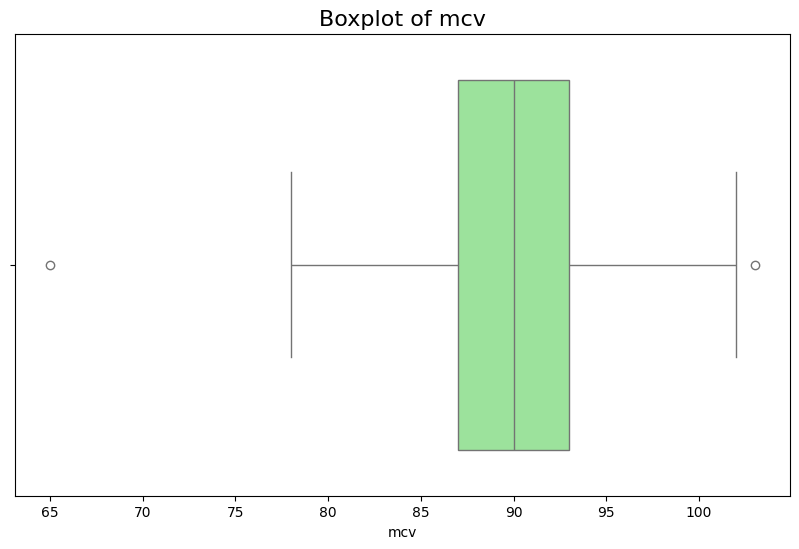

In [104]:
# Boxplot of mcv
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['mcv'], color='lightgreen')
plt.title('Boxplot of mcv', fontsize=16)
plt.xlabel('mcv')
plt.show()

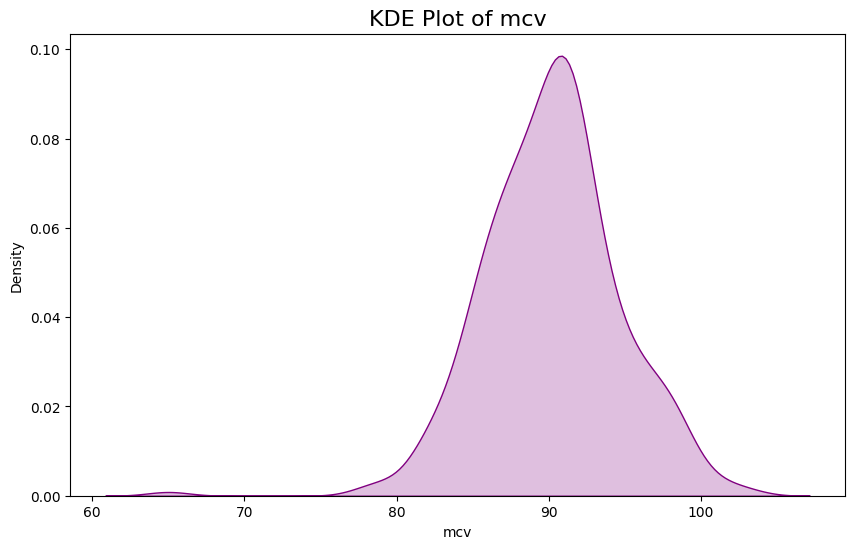

In [105]:
# KDE plot of mcv
plt.figure(figsize=(10, 6))
sns.kdeplot(df['mcv'], shade=True, color='purple')
plt.title('KDE Plot of mcv', fontsize=16)
plt.xlabel('mcv')
plt.ylabel('Density')
plt.show()

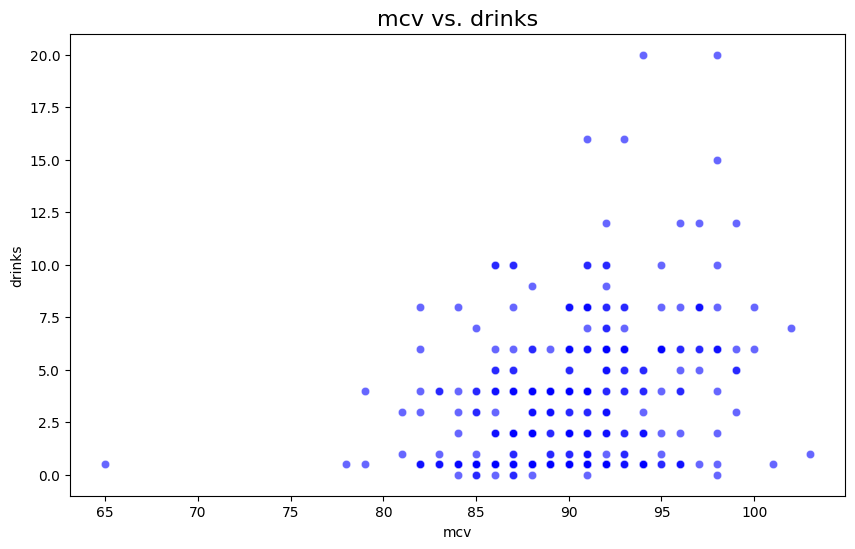

In [106]:
# Scatter plot of mcv vs. drinks
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mcv', y='drinks', data=df, color='blue', alpha=0.6)
plt.title('mcv vs. drinks', fontsize=16)
plt.xlabel('mcv')
plt.ylabel('drinks')
plt.show()

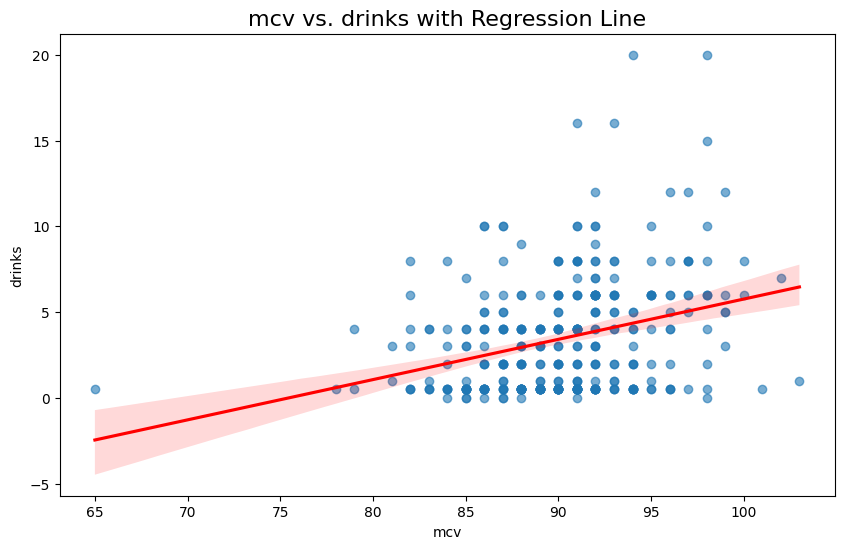

In [107]:
# Regression plot of mcv vs. drinks
plt.figure(figsize=(10, 6))
sns.regplot(x='mcv', y='drinks', data=df, scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
plt.title('mcv vs. drinks with Regression Line', fontsize=16)
plt.xlabel('mcv')
plt.ylabel('drinks')
plt.show()

####Log Transformation

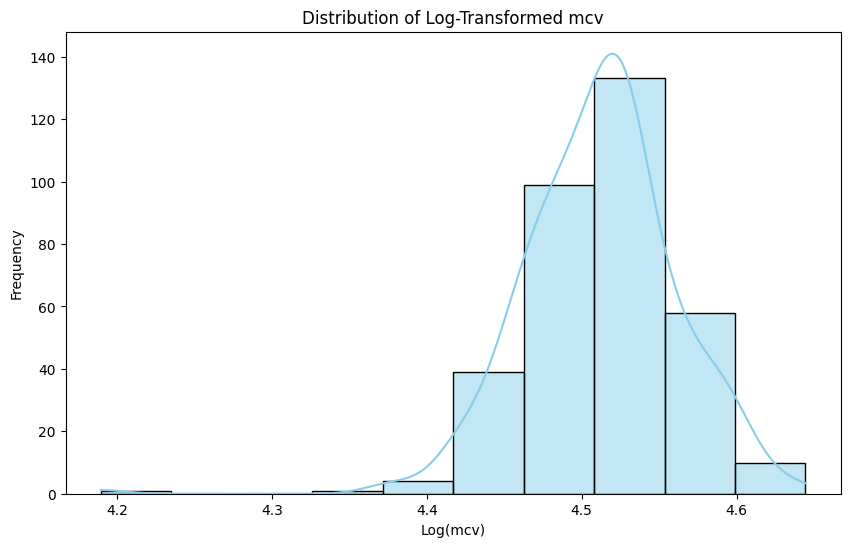

In [108]:
# Apply log transformation to 'mcv' column
df['mcv_log'] = np.log1p(df['mcv'])  # Log transformation

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['mcv_log'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed mcv')
plt.xlabel('Log(mcv)')
plt.ylabel('Frequency')
plt.show()

####Square Root Transformation

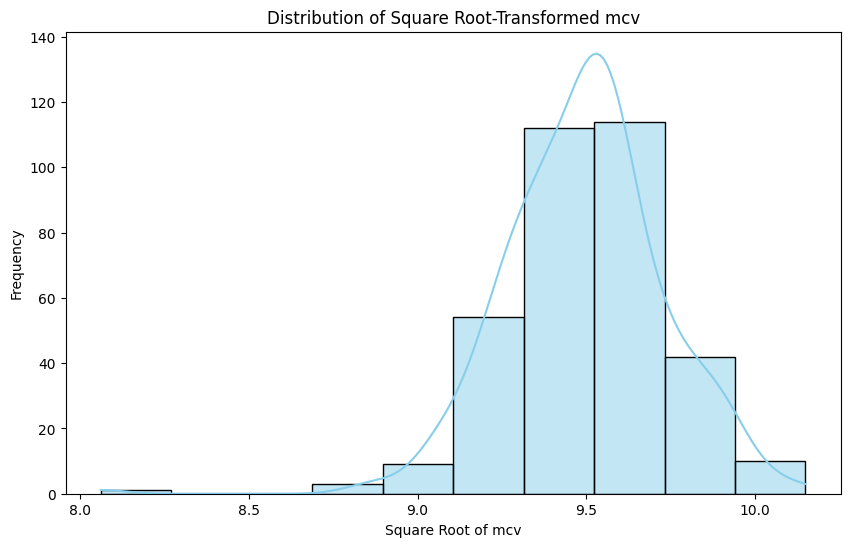

In [109]:
# Apply square root transformation to the 'mcv' column
df['mcv_sqrt'] = np.sqrt(df['mcv'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['mcv_sqrt'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Square Root-Transformed mcv')
plt.xlabel('Square Root of mcv')
plt.ylabel('Frequency')
plt.show()

####Box-Cox Transformation

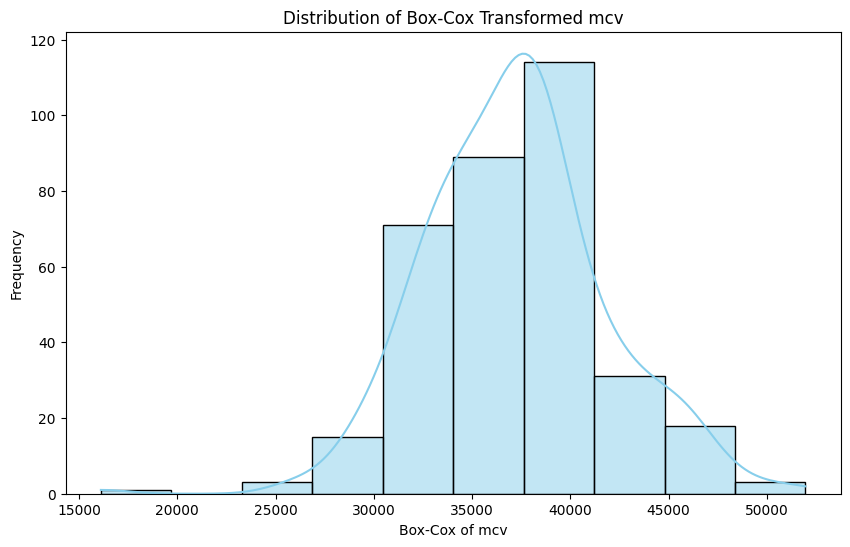

In [110]:
from scipy.stats import boxcox
# Ensure all values are positive (if necessary)
df['mcv'] = df['mcv'] + 1e-6  # Add a small constant to handle zero values

# Apply Box-Cox transformation
df['mcv_boxcox'], _ = boxcox(df['mcv'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['mcv_boxcox'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Box-Cox Transformed mcv')
plt.xlabel('Box-Cox of mcv')
plt.ylabel('Frequency')
plt.show()

####Yeo-Johnson Transformation

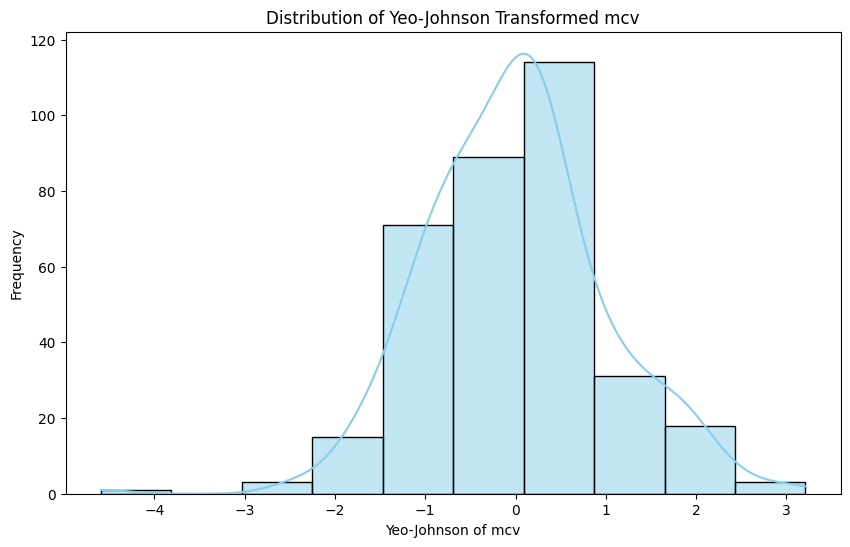

In [111]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['mcv_yeojohnson'] = pt.fit_transform(df[['mcv']])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['mcv_yeojohnson'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Yeo-Johnson Transformed mcv')
plt.xlabel('Yeo-Johnson of mcv')
plt.ylabel('Frequency')
plt.show()

###alkphos

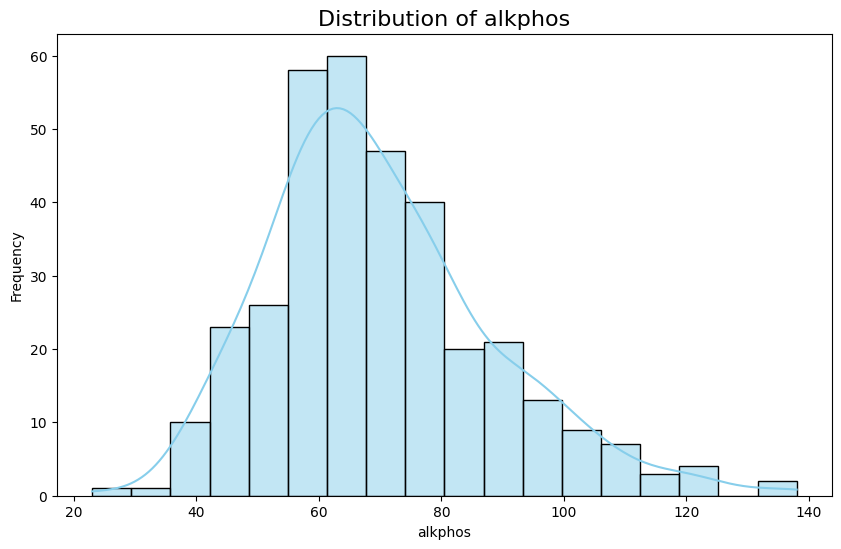

In [112]:
# Histogram of alkphos
plt.figure(figsize=(10, 6))
sns.histplot(df['alkphos'], kde=True, color='skyblue')
plt.title('Distribution of alkphos', fontsize=16)
plt.xlabel('alkphos')
plt.ylabel('Frequency')
plt.show()

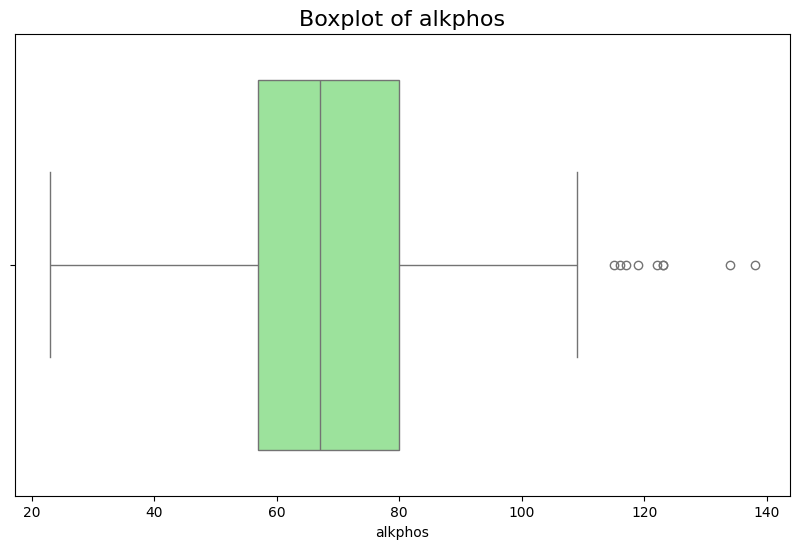

In [113]:
# Boxplot of alkphos
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['alkphos'], color='lightgreen')
plt.title('Boxplot of alkphos', fontsize=16)
plt.xlabel('alkphos')
plt.show()

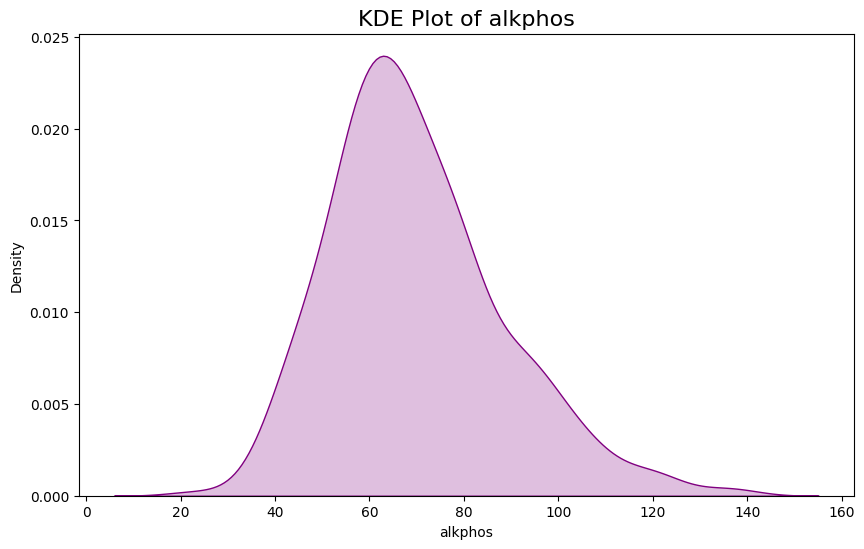

In [114]:
# KDE plot of alkphos
plt.figure(figsize=(10, 6))
sns.kdeplot(df['alkphos'], shade=True, color='purple')
plt.title('KDE Plot of alkphos', fontsize=16)
plt.xlabel('alkphos')
plt.ylabel('Density')
plt.show()

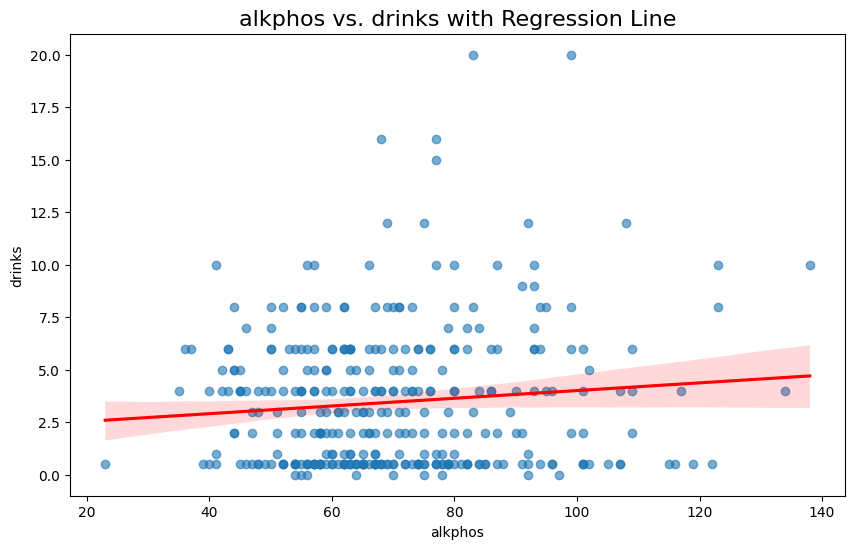

In [115]:
# Scatter plot with regression line of alkphos vs. drinks
plt.figure(figsize=(10, 6))
sns.regplot(x='alkphos', y='drinks', data=df, scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
plt.title('alkphos vs. drinks with Regression Line', fontsize=16)
plt.xlabel('alkphos')
plt.ylabel('drinks')
plt.show()

####Log Transformation

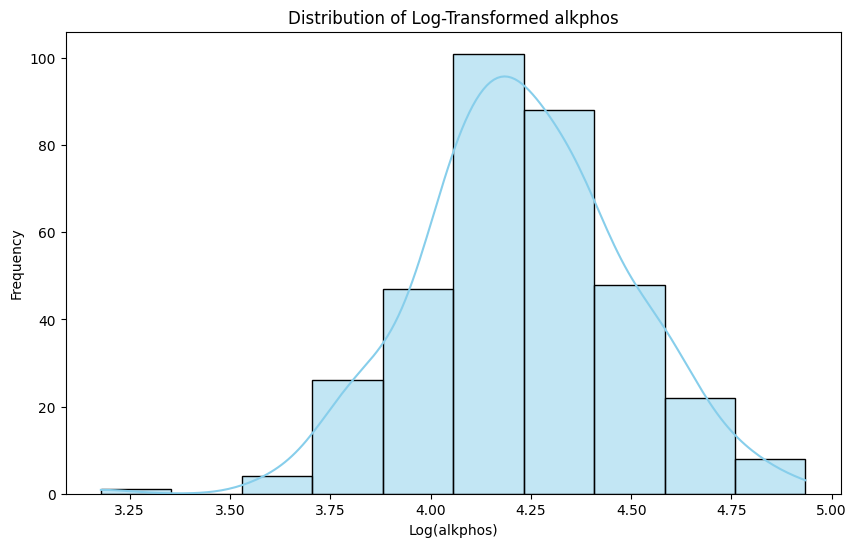

In [116]:
# Apply log transformation to 'alkphos' column
df['alkphos_log'] = np.log1p(df['alkphos'])  # Log transformation

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['alkphos_log'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed alkphos')
plt.xlabel('Log(alkphos)')
plt.ylabel('Frequency')
plt.show()

####Square Root Transformation

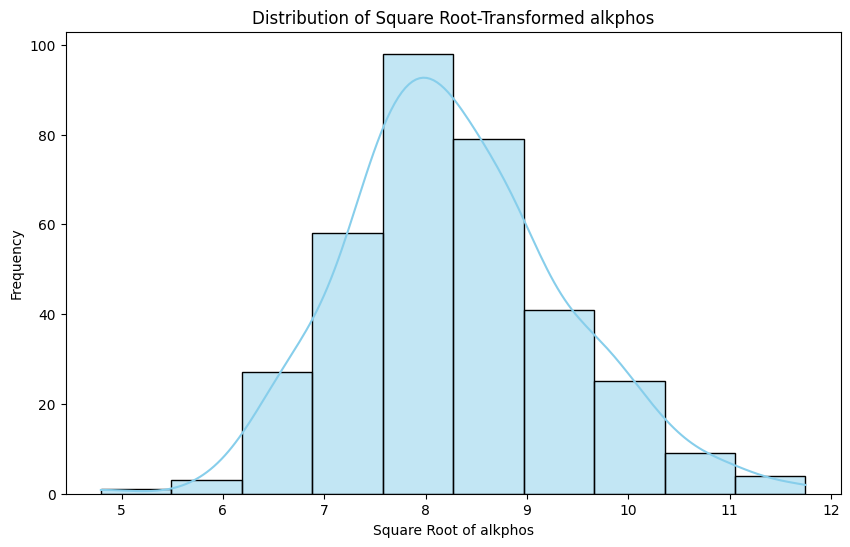

In [117]:
# Apply square root transformation to the 'alkphos' column
df['alkphos_sqrt'] = np.sqrt(df['alkphos'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['alkphos_sqrt'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Square Root-Transformed alkphos')
plt.xlabel('Square Root of alkphos')
plt.ylabel('Frequency')
plt.show()

####Box-Cox Transformation

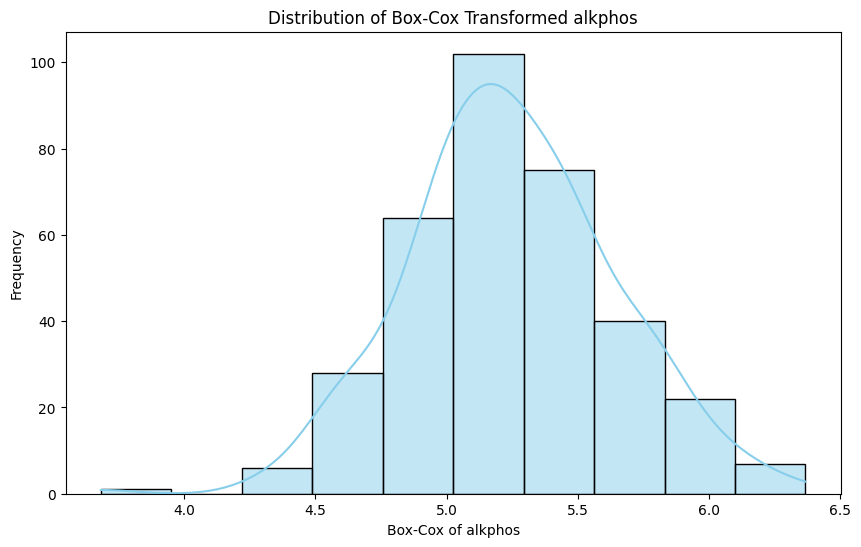

In [118]:
from scipy.stats import boxcox
# Ensure all values are positive (if necessary)
df['alkphos'] = df['alkphos'] + 1e-6  # Add a small constant to handle zero values

# Apply Box-Cox transformation
df['alkphos_boxcox'], _ = boxcox(df['alkphos'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['alkphos_boxcox'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Box-Cox Transformed alkphos')
plt.xlabel('Box-Cox of alkphos')
plt.ylabel('Frequency')
plt.show()

####Yeo-Johnson Transformation

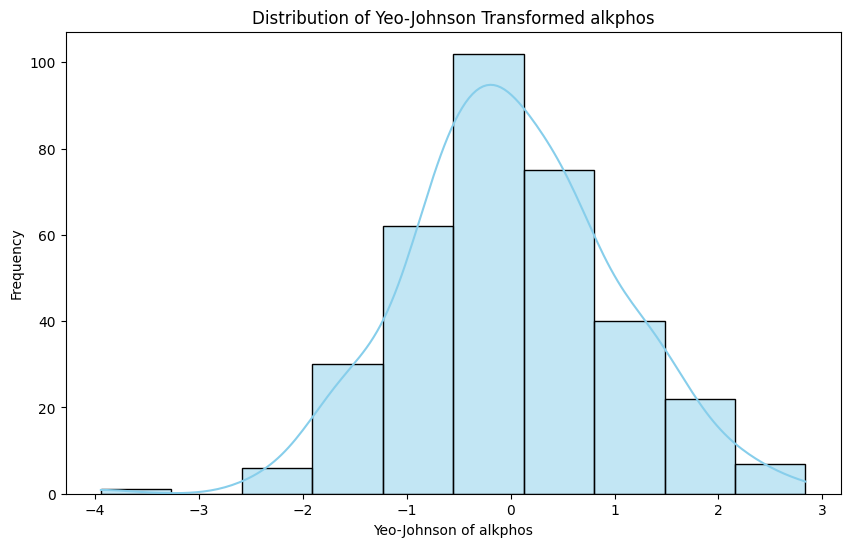

In [119]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['alkphos_yeojohnson'] = pt.fit_transform(df[['alkphos']])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['alkphos_yeojohnson'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Yeo-Johnson Transformed alkphos')
plt.xlabel('Yeo-Johnson of alkphos')
plt.ylabel('Frequency')
plt.show()

###sgpt

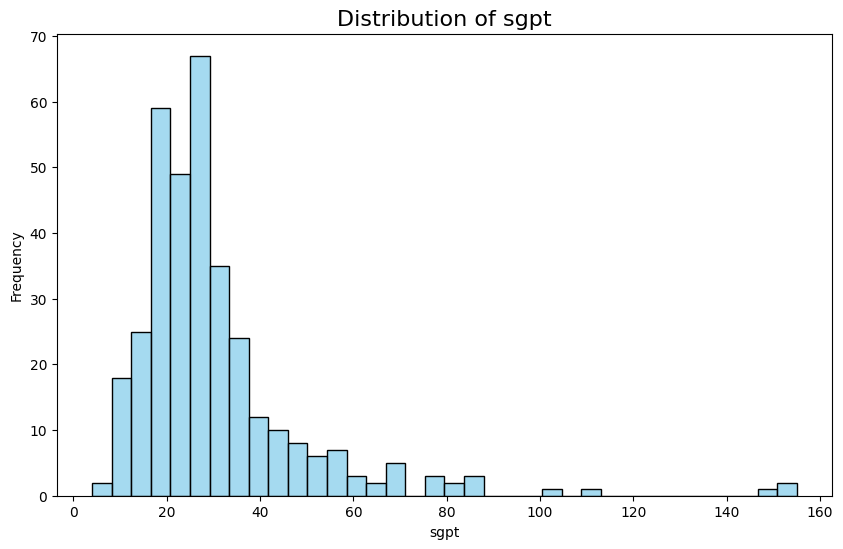

In [120]:
# Histogram of sgpt
plt.figure(figsize=(10, 6))
sns.histplot(df['sgpt'], kde=False, color='skyblue')
plt.title('Distribution of sgpt', fontsize=16)
plt.xlabel('sgpt')
plt.ylabel('Frequency')
plt.show()

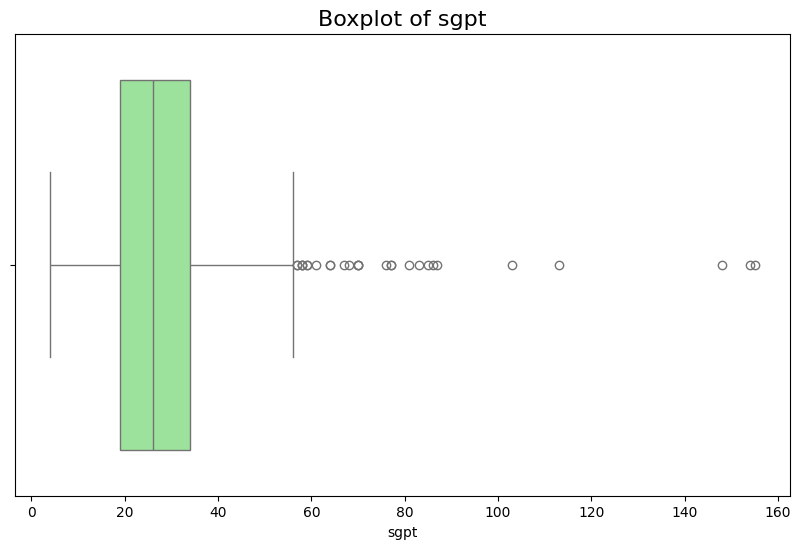

In [121]:
# Boxplot of sgpt
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sgpt'], color='lightgreen')
plt.title('Boxplot of sgpt', fontsize=16)
plt.xlabel('sgpt')
plt.show()

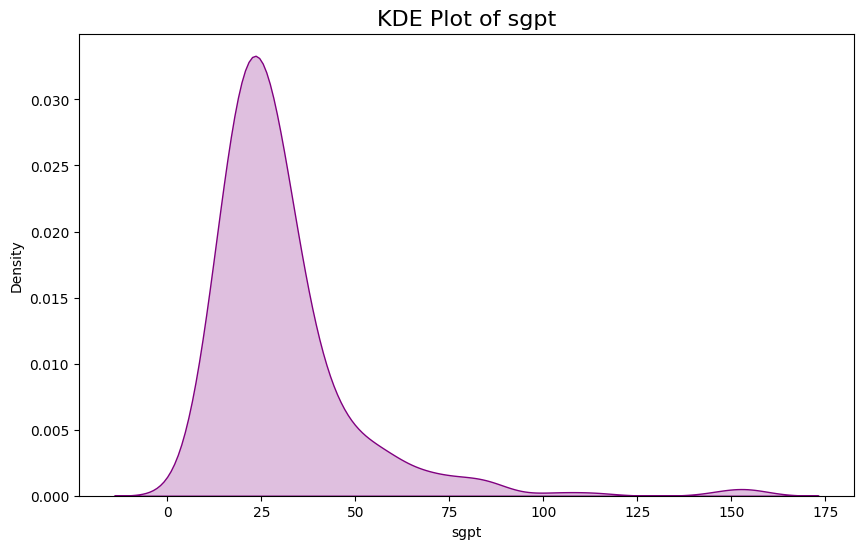

In [122]:
# KDE plot of sgpt
plt.figure(figsize=(10, 6))
sns.kdeplot(df['sgpt'], shade=True, color='purple')
plt.title('KDE Plot of sgpt', fontsize=16)
plt.xlabel('sgpt')
plt.ylabel('Density')
plt.show()

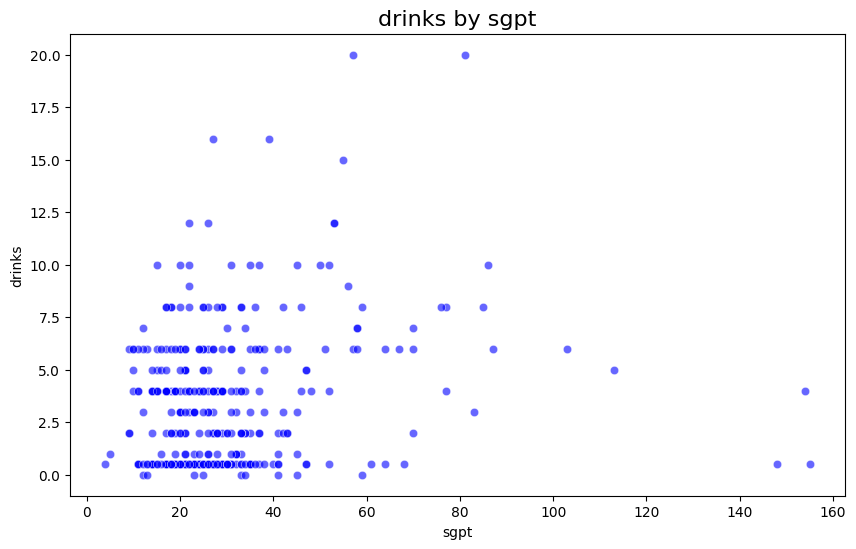

In [123]:
# Scatter plot of drinks by sgpt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sgpt', y='drinks', data=df, color='blue', alpha=0.6)
plt.title('drinks by sgpt', fontsize=16)
plt.xlabel('sgpt')
plt.ylabel('drinks')
plt.show()

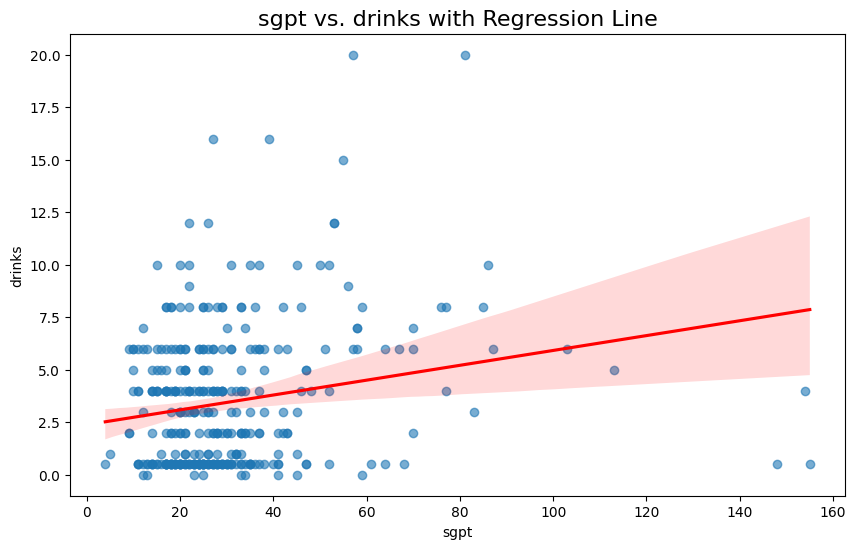

In [124]:
# Regression plot of drinks by sgpt
plt.figure(figsize=(10, 6))
sns.regplot(x='sgpt', y='drinks', data=df, scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
plt.title('sgpt vs. drinks with Regression Line', fontsize=16)
plt.xlabel('sgpt')
plt.ylabel('drinks')
plt.show()

####Log Transformation

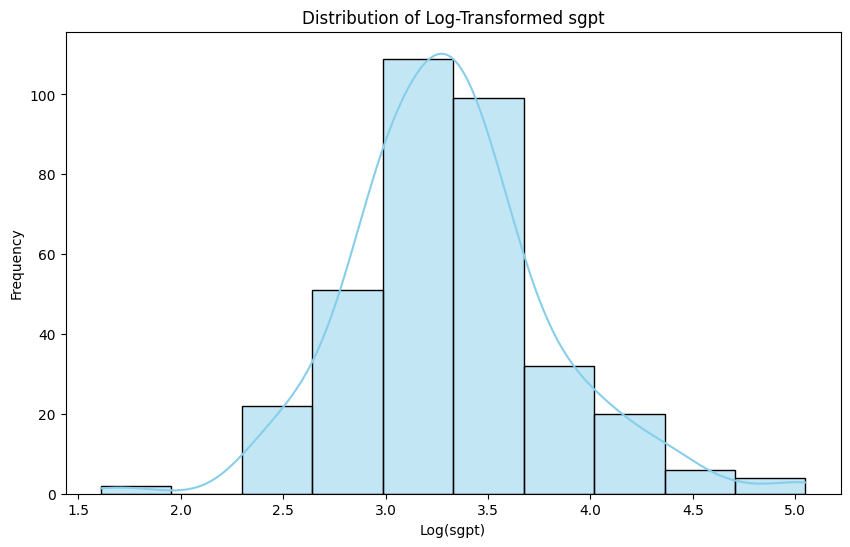

In [125]:
# Apply log transformation to 'sgpt' column
df['sgpt_log'] = np.log1p(df['sgpt'])  # Log transformation

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgpt_log'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed sgpt')
plt.xlabel('Log(sgpt)')
plt.ylabel('Frequency')
plt.show()

####Square Root Transformation

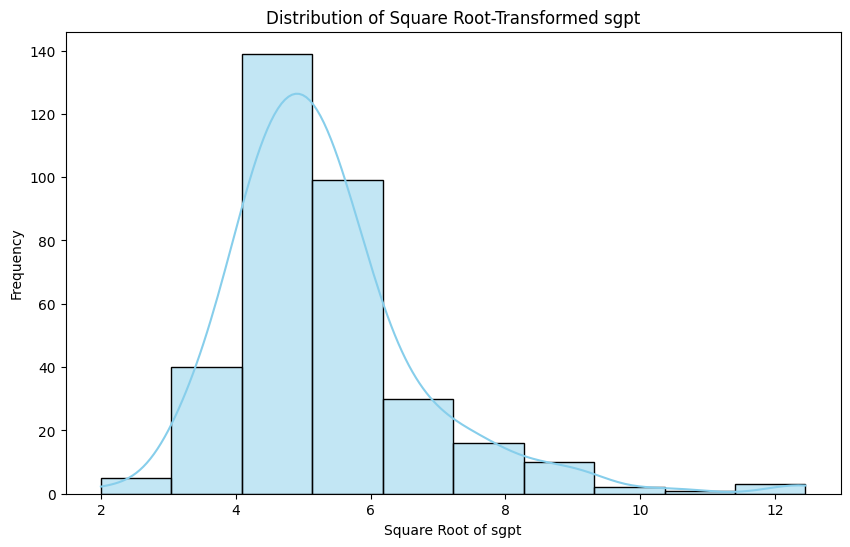

In [126]:
# Apply square root transformation to the 'sgpt' column
df['sgpt_sqrt'] = np.sqrt(df['sgpt'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgpt_sqrt'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Square Root-Transformed sgpt')
plt.xlabel('Square Root of sgpt')
plt.ylabel('Frequency')
plt.show()

####Box-Cox Transformation

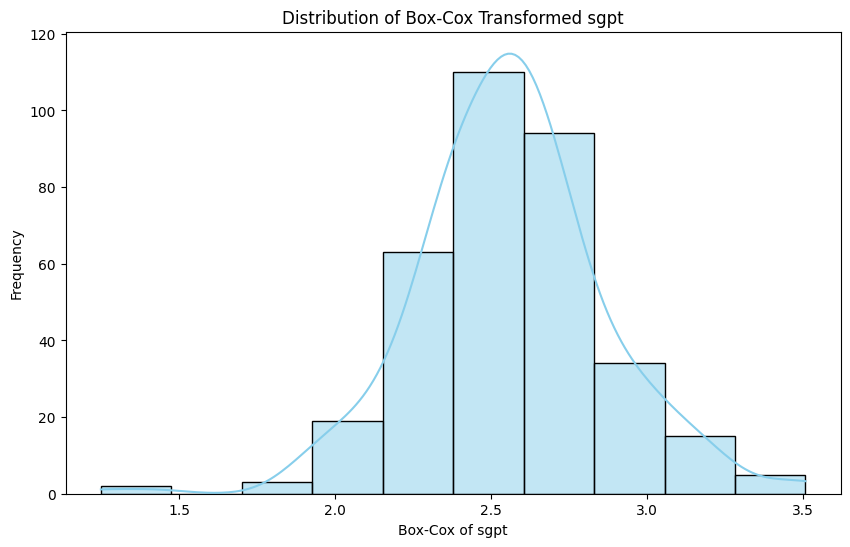

In [127]:
from scipy.stats import boxcox
# Ensure all values are positive (if necessary)
df['sgpt'] = df['sgpt'] + 1e-6  # Add a small constant to handle zero values

# Apply Box-Cox transformation
df['sgpt_boxcox'], _ = boxcox(df['sgpt'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgpt_boxcox'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Box-Cox Transformed sgpt')
plt.xlabel('Box-Cox of sgpt')
plt.ylabel('Frequency')
plt.show()

####Yeo-Johnson Transformation

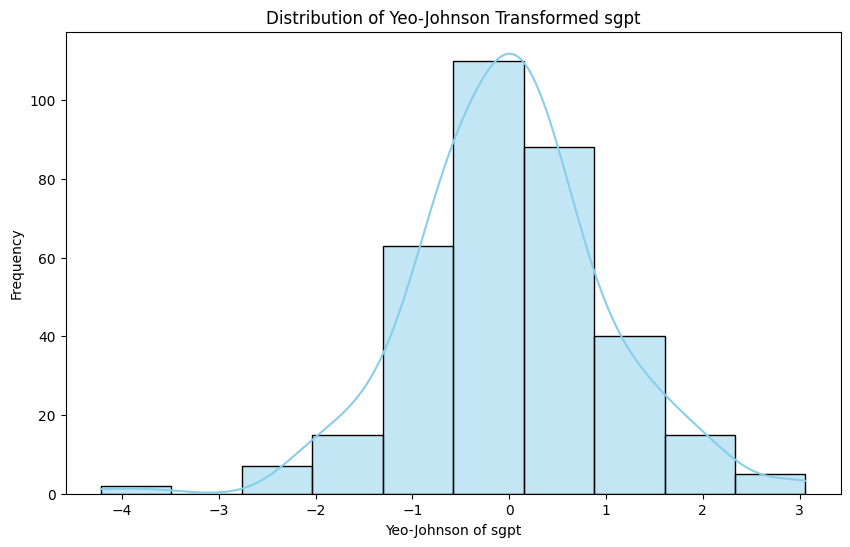

In [128]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['sgpt_yeojohnson'] = pt.fit_transform(df[['sgpt']])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgpt_yeojohnson'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Yeo-Johnson Transformed sgpt')
plt.xlabel('Yeo-Johnson of sgpt')
plt.ylabel('Frequency')
plt.show()

###sgot

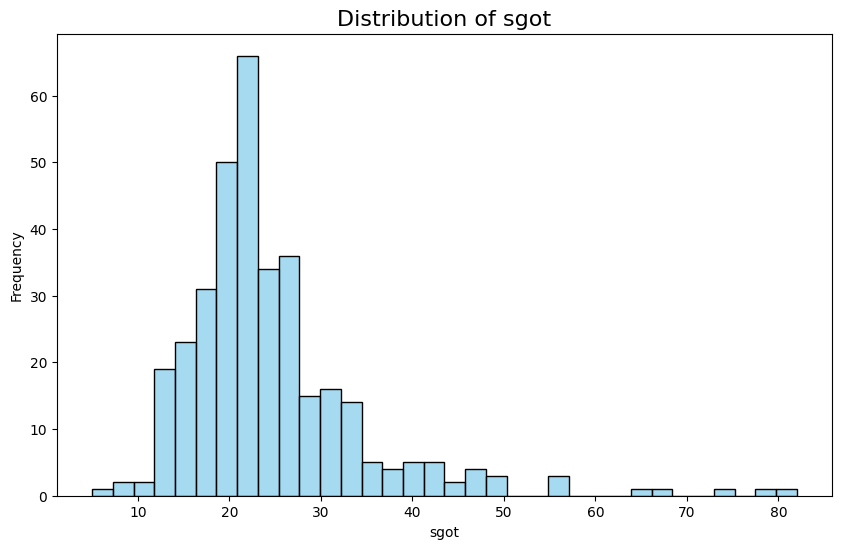

In [129]:
# Histogram of sgot
plt.figure(figsize=(10, 6))
sns.histplot(df['sgot'], kde=False, color='skyblue')
plt.title('Distribution of sgot', fontsize=16)
plt.xlabel('sgot')
plt.ylabel('Frequency')
plt.show()

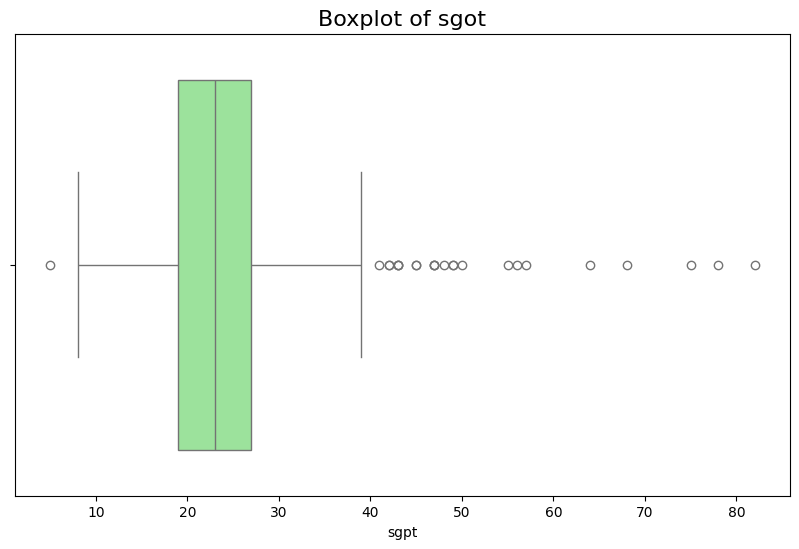

In [130]:
# Boxplot of sgot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sgot'], color='lightgreen')
plt.title('Boxplot of sgot', fontsize=16)
plt.xlabel('sgpt')
plt.show()

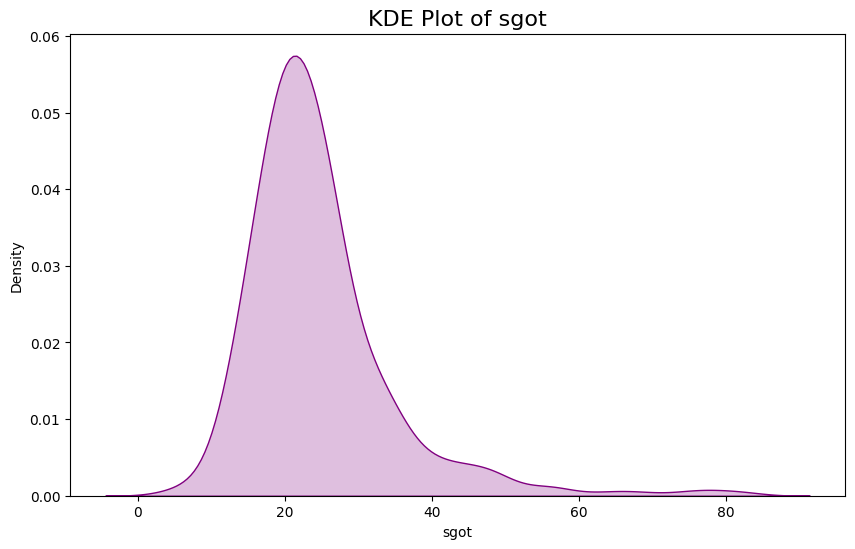

In [131]:
# KDE plot of sgot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['sgot'], shade=True, color='purple')
plt.title('KDE Plot of sgot', fontsize=16)
plt.xlabel('sgot')
plt.ylabel('Density')
plt.show()

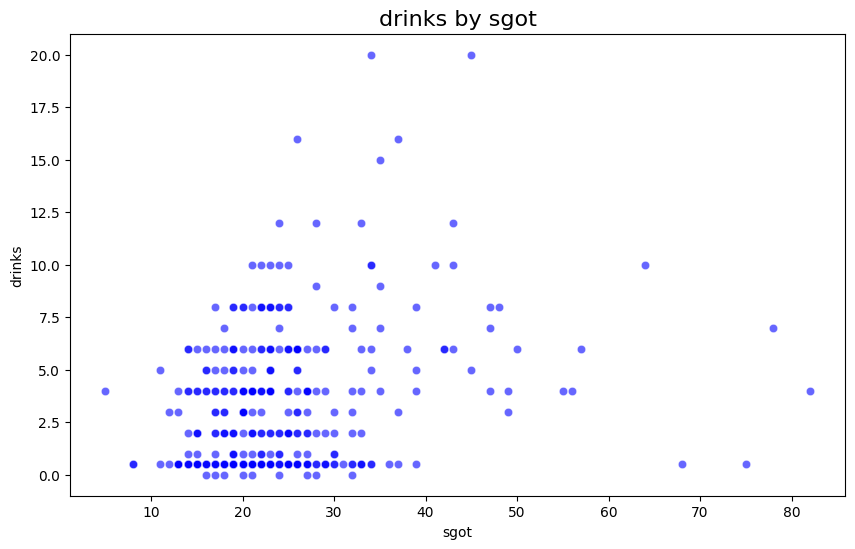

In [132]:
# Scatter plot of drinks by sgot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sgot', y='drinks', data=df, color='blue', alpha=0.6)
plt.title('drinks by sgot', fontsize=16)
plt.xlabel('sgot')
plt.ylabel('drinks')
plt.show()

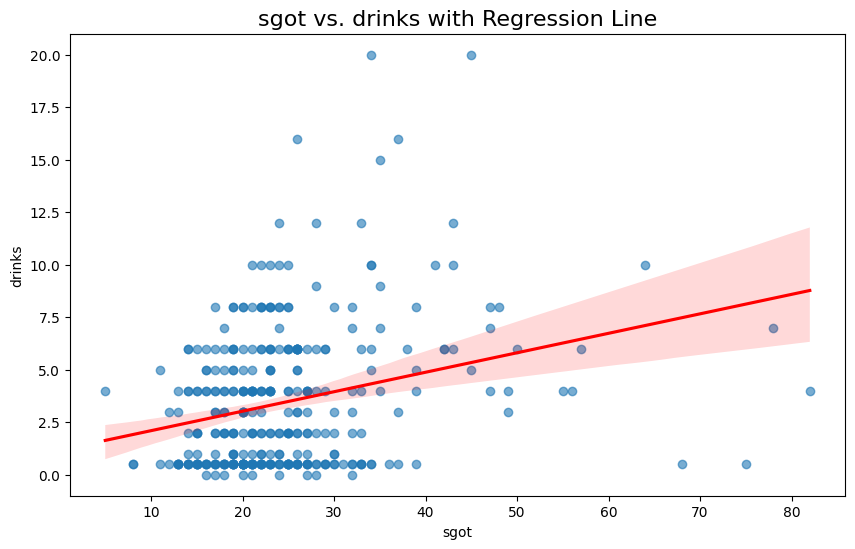

In [133]:
# Regression plot of drinks by sgot
plt.figure(figsize=(10, 6))
sns.regplot(x='sgot', y='drinks', data=df, scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
plt.title('sgot vs. drinks with Regression Line', fontsize=16)
plt.xlabel('sgot')
plt.ylabel('drinks')
plt.show()

####Log Transformation

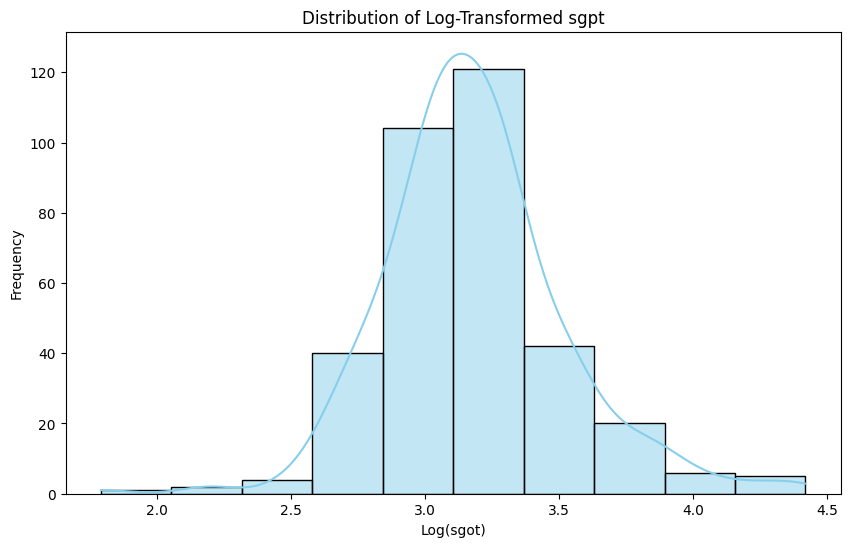

In [134]:
# Apply log transformation to 'sgot' column
df['sgot_log'] = np.log1p(df['sgot'])  # Log transformation

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgot_log'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed sgpt')
plt.xlabel('Log(sgot)')
plt.ylabel('Frequency')
plt.show()

####Square Root Transformation

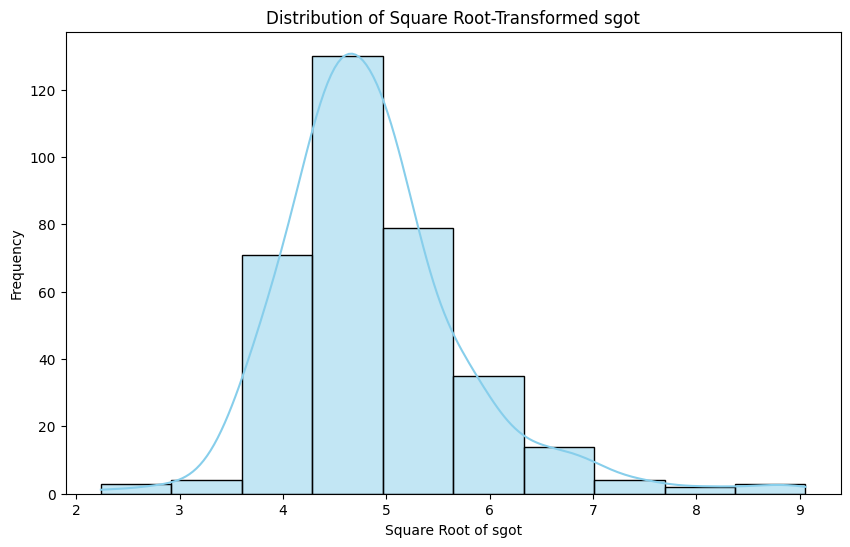

In [135]:
# Apply square root transformation to the 'sgot' column
df['sgot_sqrt'] = np.sqrt(df['sgot'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgot_sqrt'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Square Root-Transformed sgot')
plt.xlabel('Square Root of sgot')
plt.ylabel('Frequency')
plt.show()

####Box-Cox Transformation

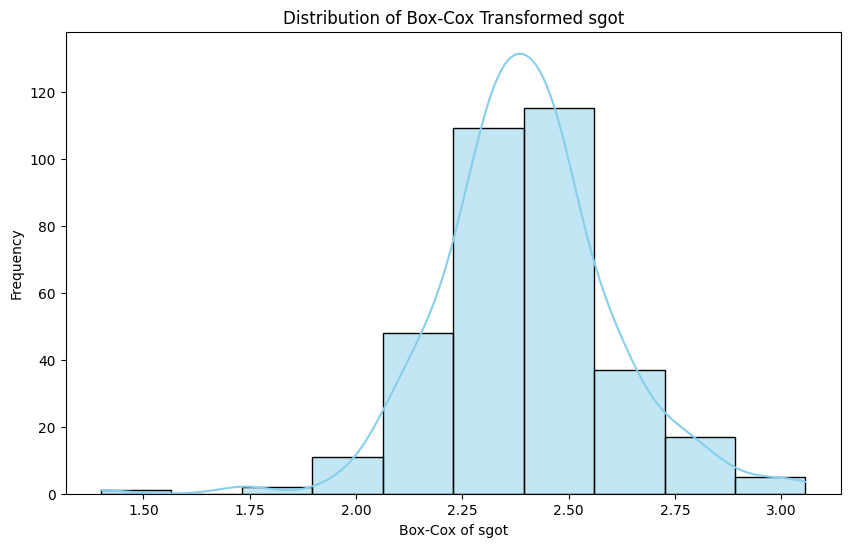

In [136]:
from scipy.stats import boxcox
# Ensure all values are positive (if necessary)
df['sgot'] = df['sgot'] + 1e-6  # Add a small constant to handle zero values

# Apply Box-Cox transformation
df['sgot_boxcox'], _ = boxcox(df['sgot'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgot_boxcox'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Box-Cox Transformed sgot')
plt.xlabel('Box-Cox of sgot')
plt.ylabel('Frequency')
plt.show()

####Yeo-Johnson Transformation

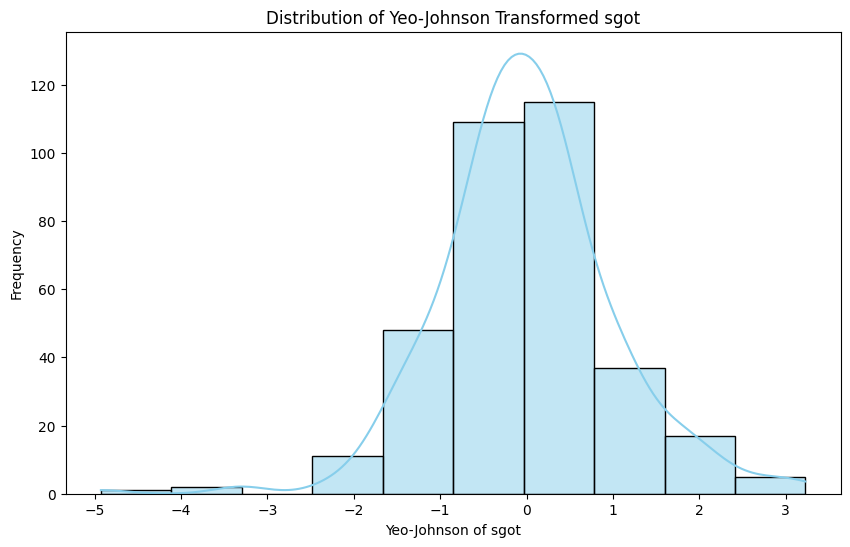

In [137]:
from sklearn.preprocessing import PowerTransformer
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['sgot_yeojohnson'] = pt.fit_transform(df[['sgot']])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sgot_yeojohnson'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Yeo-Johnson Transformed sgot')
plt.xlabel('Yeo-Johnson of sgot')
plt.ylabel('Frequency')
plt.show()

###gammagt

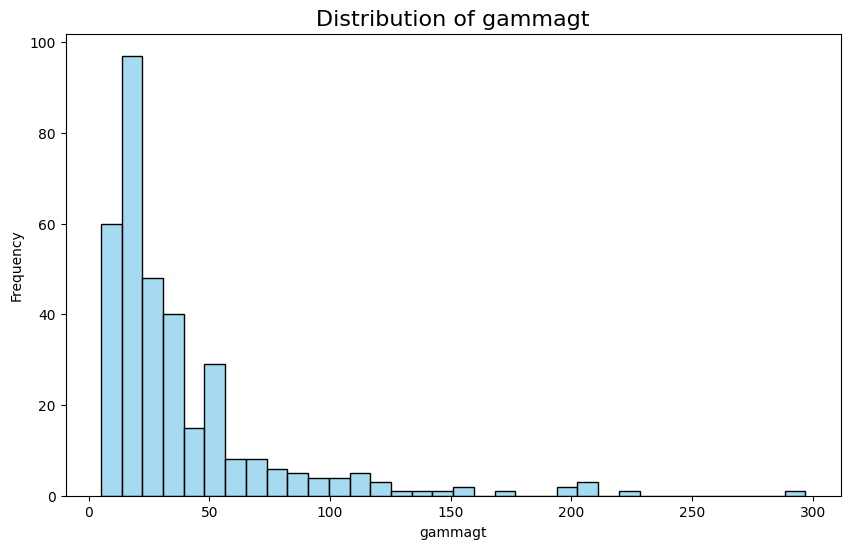

In [138]:
# Histogram of gammagt
plt.figure(figsize=(10, 6))
sns.histplot(df['gammagt'], kde=False, color='skyblue')
plt.title('Distribution of gammagt', fontsize=16)
plt.xlabel('gammagt')
plt.ylabel('Frequency')
plt.show()

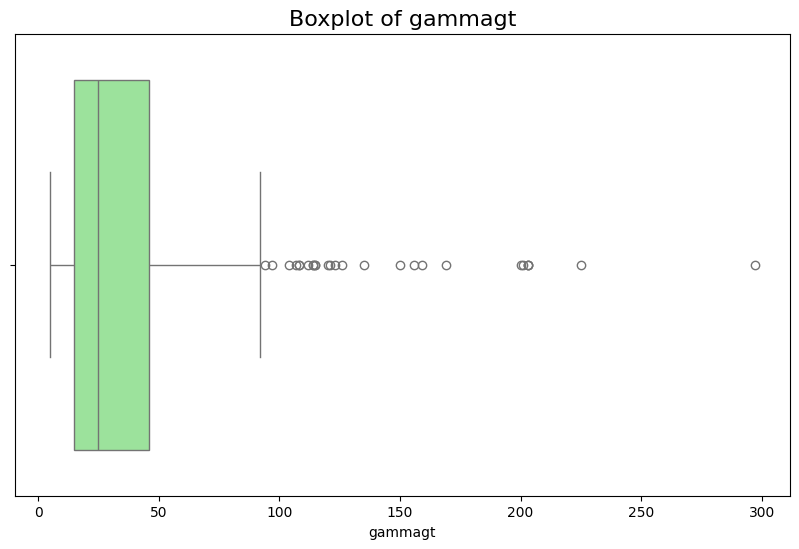

In [139]:
# Boxplot of gammagt
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['gammagt'], color='lightgreen')
plt.title('Boxplot of gammagt', fontsize=16)
plt.xlabel('gammagt')
plt.show()

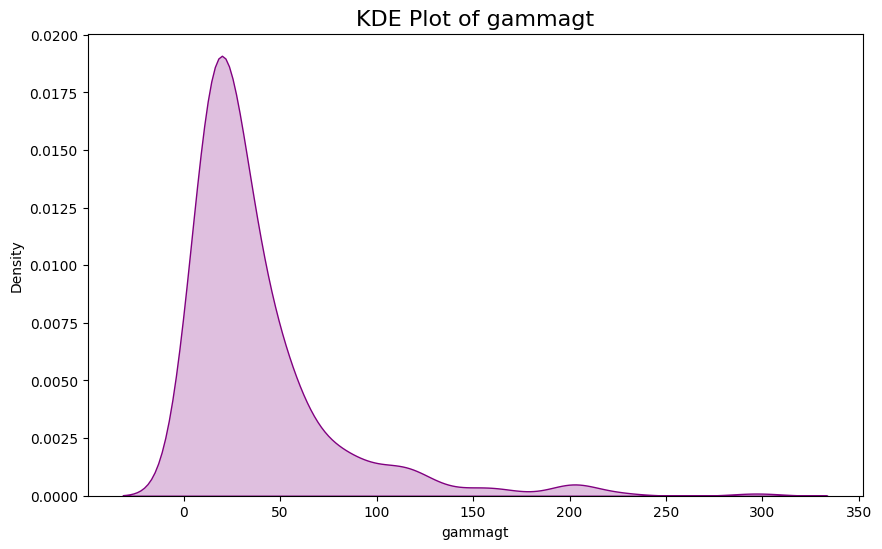

In [140]:
# KDE plot of gammagt
plt.figure(figsize=(10, 6))
sns.kdeplot(df['gammagt'], shade=True, color='purple')
plt.title('KDE Plot of gammagt', fontsize=16)
plt.xlabel('gammagt')
plt.ylabel('Density')
plt.show()

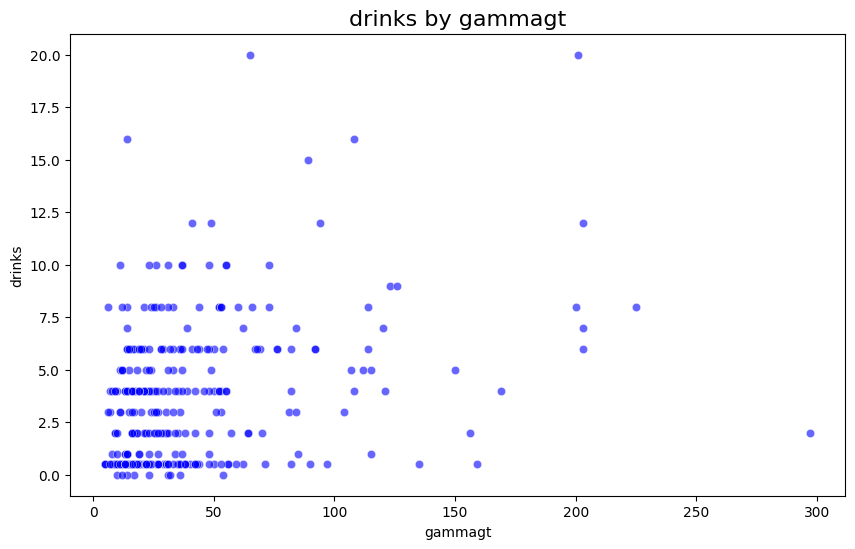

In [141]:
# Scatter plot of drinks by gammagt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gammagt', y='drinks', data=df, color='blue', alpha=0.6)
plt.title('drinks by gammagt', fontsize=16)
plt.xlabel('gammagt')
plt.ylabel('drinks')
plt.show()

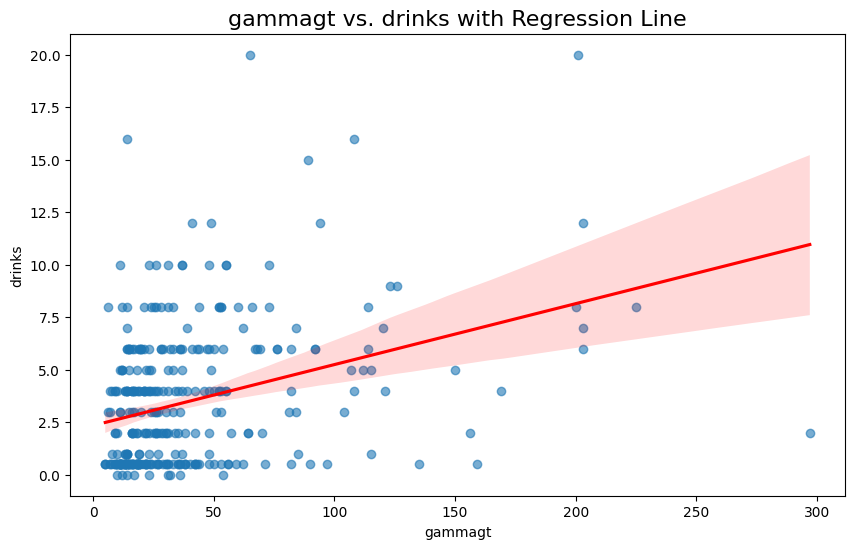

In [142]:
# Regression plot of drinks by gammagt
plt.figure(figsize=(10, 6))
sns.regplot(x='gammagt', y='drinks', data=df, scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
plt.title('gammagt vs. drinks with Regression Line', fontsize=16)
plt.xlabel('gammagt')
plt.ylabel('drinks')
plt.show()

##5.Predictive Modeling

###Model Training

#### Feature Engineering

In [143]:
# Create interaction terms
df['mcv_sgot'] = df['mcv'] * df['sgot']  # Interaction between mcv and sgot
df['alkphos_sgpt'] = df['alkphos'] * df['sgpt']  # Interaction between alkphos and sgpt
df['sgpt_gammagt'] = df['sgpt'] * df['gammagt']  # Interaction between sgpt and gammagt
df['mcv_alkphos'] = df['mcv'] * df['alkphos']  # Interaction between mcv and alkphos
df['sgot_gammagt'] = df['sgot'] * df['gammagt']  # Interaction between sgot and gammagt

In [144]:
df.head()

,mcv,alkphos,sgpt,sgot,gammagt,drinks,drinks_log,drinks_sqrt,drinks_boxcox,drinks_yeojohnson,...,sgpt_yeojohnson,sgot_log,sgot_sqrt,sgot_boxcox,sgot_yeojohnson,mcv_sgot,alkphos_sgpt,sgpt_gammagt,mcv_alkphos,sgot_gammagt
0,85.000001,92.000001,45.000001,27.000001,31,0.000001,0.0,0.0,-3.204148,-1.74169,...,1.058732,3.332205,5.196152,2.494867,0.477826,2295.000112,4140.000137,1395.000031,7820.000177,837.000031
1,85.000001,64.000001,59.000001,32.000001,23,0.000001,0.0,0.0,-3.204148,-1.74169,...,1.539335,3.496508,5.656854,2.588075,0.942333,2720.000117,3776.000123,1357.000023,5440.000149,736.000023
2,86.000001,54.000001,33.000001,16.000001,54,0.000001,0.0,0.0,-3.204148,-1.74169,...,0.477922,2.833213,4.000000,2.189486,-1.053806,1376.000102,1782.000087,1782.000054,4644.000140,864.000054
3,91.000001,78.000001,34.000001,24.000001,36,0.000001,0.0,0.0,-3.204148,-1.74169,...,0.535252,3.218876,4.898979,2.428579,0.146299,2184.000115,2652.000112,1224.000036,7098.000169,864.000036
4,87.000001,70.000001,12.000001,28.000001,10,0.000001,0.0,0.0,-3.204148,-1.74169,...,-1.638215,3.367296,5.291503,2.515056,0.578618,2436.000115,840.000082,120.000010,6090.000157,280.000010


####Data Preparating

In [145]:
df.columns

Index(['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'drinks_log',
       'drinks_sqrt', 'drinks_boxcox', 'drinks_yeojohnson', 'mcv_log',
       'mcv_sqrt', 'mcv_boxcox', 'mcv_yeojohnson', 'alkphos_log',
       'alkphos_sqrt', 'alkphos_boxcox', 'alkphos_yeojohnson', 'sgpt_log',
       'sgpt_sqrt', 'sgpt_boxcox', 'sgpt_yeojohnson', 'sgot_log', 'sgot_sqrt',
       'sgot_boxcox', 'sgot_yeojohnson', 'mcv_sgot', 'alkphos_sgpt',
       'sgpt_gammagt', 'mcv_alkphos', 'sgot_gammagt'],
      dtype='object')

In [164]:
# Prepare the features (X) and target (y)
X = df[['mcv', 'sgot','sgpt', 'gammagt']]  # Features
y = df['drinks']  # target variable

In [165]:
# Specify numerical columns in the DataFrame
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns

['mcv', 'sgot', 'sgpt', 'gammagt']

In [167]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # Standardize numerical features
    ]
)

In [168]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####Model Selection and Training

In [169]:
# List of models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Support Vector Regression (SVR)': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'K-Nearest Neighbors Regression (KNN)': KNeighborsRegressor(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Huber Regression': HuberRegressor(),
    'Quantile Regression': QuantileRegressor(),
    'Principal Component Regression (PCR)': make_pipeline(PCA(), LinearRegression()),
    'Partial Least Squares Regression (PLS)': PLSRegression(),
    'Theil-Sen Estimator': TheilSenRegressor(),
    'RANSAC Regression': RANSACRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting Machines (GBM)': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'Stochastic Gradient Boosting': GradientBoostingRegressor(subsample=0.5, random_state=42),
    'Quantile Boosting': GradientBoostingRegressor(loss='quantile', random_state=42)
}


In [177]:
# Function to train and evaluate each model
results = {'Model': [], 'MAE': [], 'MSE': [], 'R-squared': []}

for model_name, model in models.items():
    # Set the solver for QuantileRegressor to 'highs'
    if model_name == 'Quantile Regression':
        model.set_params(solver='highs')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results['Model'].append(model_name)
    results['MAE'].append(mean_absolute_error(y_test, y_pred))
    results['MSE'].append(mean_squared_error(y_test, y_pred))
    results['R-squared'].append(r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 4
[LightGBM] [Info] Start training from score 3.447465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

###Model Evaluation

In [171]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='R-squared', ascending= False, inplace=True)

# Display the results
results_df

,Model,MAE,MSE,R-squared
21,HistGradientBoosting,2.246213,8.099964,0.239063
19,LightGBM,2.308390,8.322870,0.218122
20,CatBoost,2.328611,8.852017,0.168412
16,AdaBoost,2.527830,8.858693,0.167785
5,Support Vector Regression (SVR),2.346300,9.072710,0.147680
7,Random Forest Regression,2.482246,9.170456,0.138497
22,Stochastic Gradient Boosting,2.398536,9.223975,0.133469
3,Elastic Net Regression,2.586163,9.750153,0.084038
17,Gradient Boosting Machines (GBM),2.453650,9.884819,0.071387
13,Partial Least Squares Regression (PLS),2.587563,10.110455,0.050190


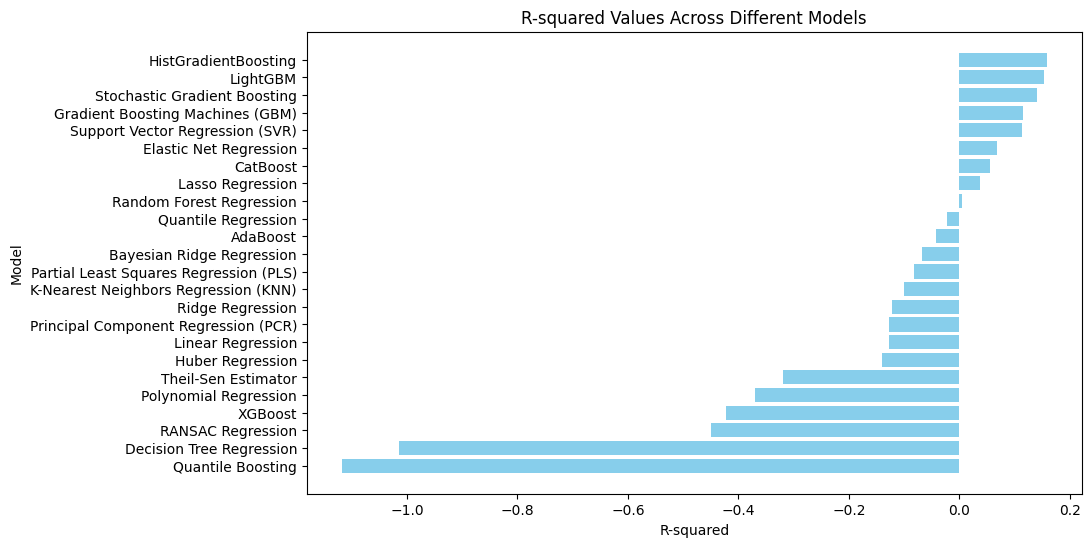

In [153]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['R-squared'], color='skyblue')
plt.xlabel('R-squared')
plt.ylabel('Model')
plt.title('R-squared Values Across Different Models')
plt.gca().invert_yaxis()  # Invert y-axis to have the best model on top
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 4
[LightGBM] [Info] Start training from score 3.447465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

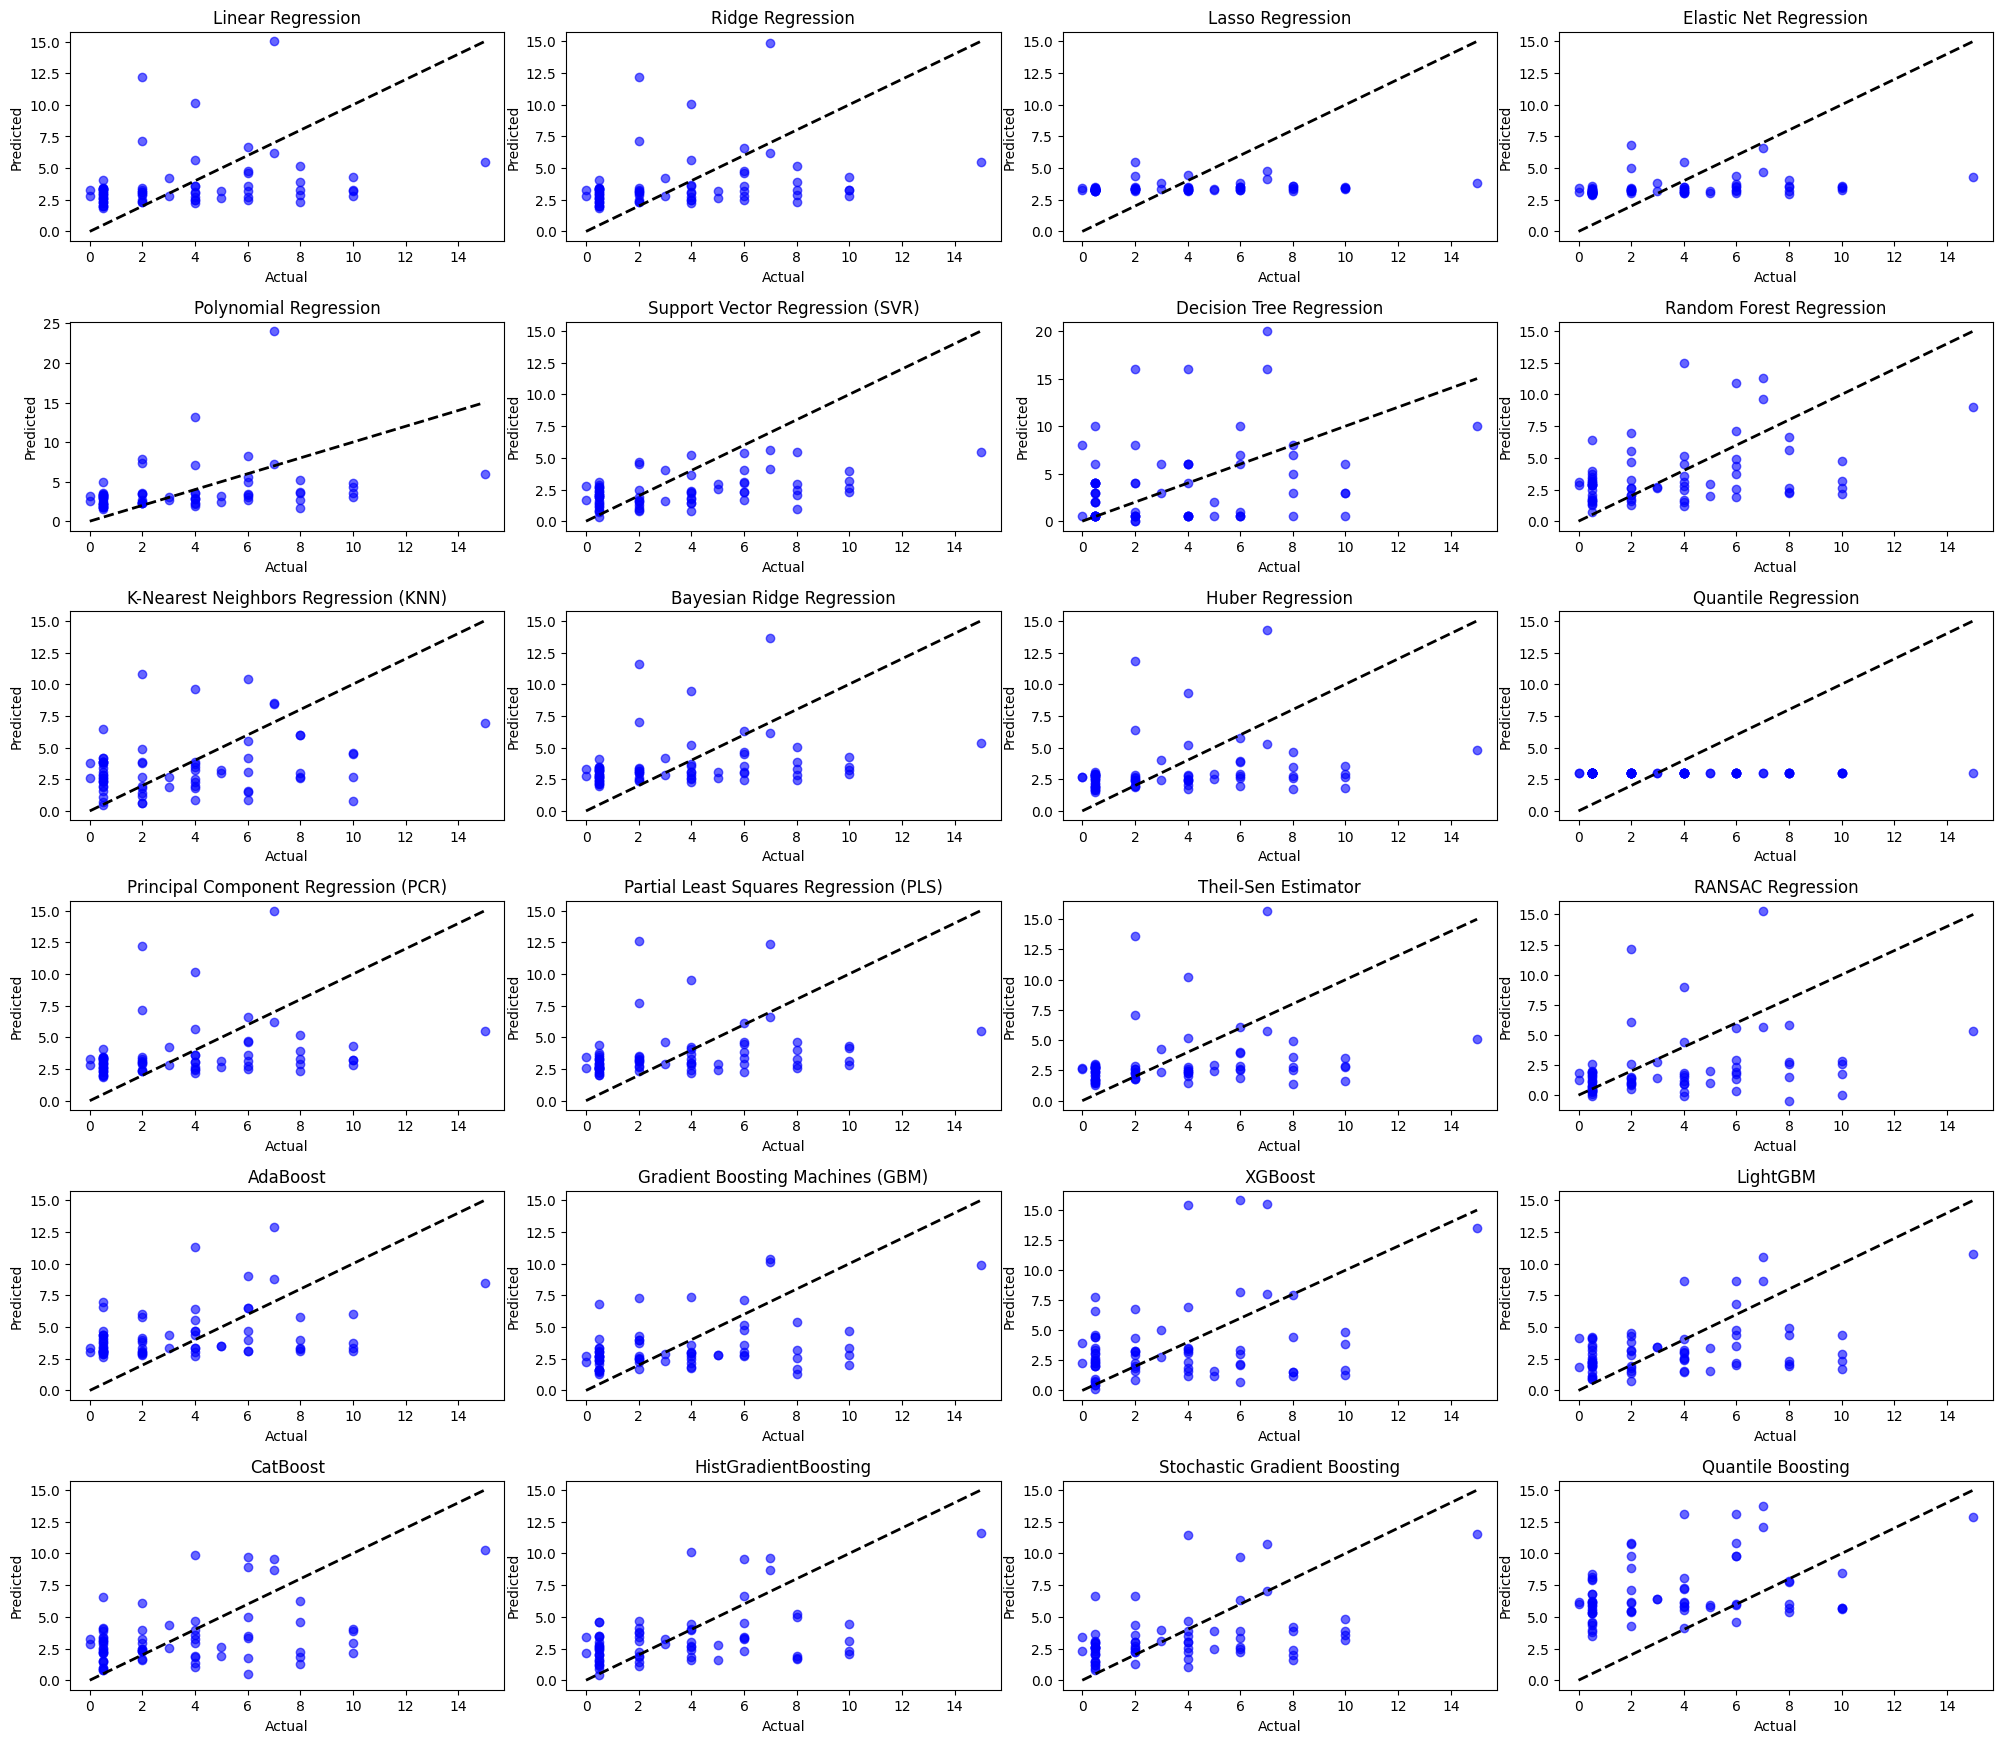

In [154]:
# Plotting the results
plt.figure(figsize=(20, 20))
n_models = len(models)
n_cols = 4
n_rows = (n_models // n_cols) + 1

for i, (model_name, model) in enumerate(models.items(), 1):
    # Pipeline for preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)

    # Generate predictions on the test data
    y_test_pred = pipeline.predict(X_test)

    # Subplot for each model
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='b')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(model_name)

plt.tight_layout()
plt.show()

###Best Model

####Principal Component Analysis (PCA)

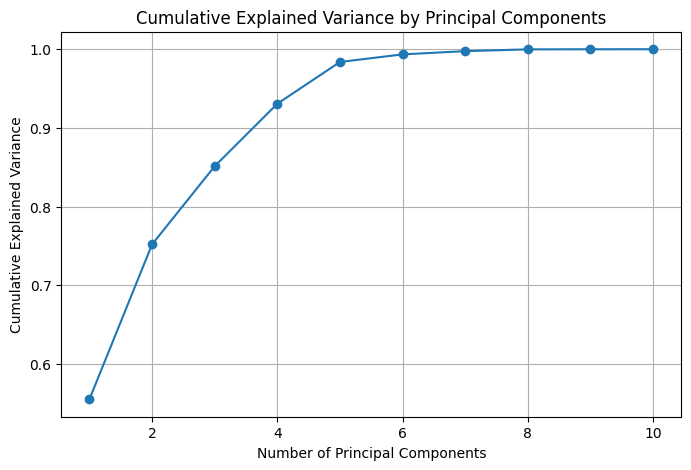

Explained variance by each component: [5.55065428e-01 1.96862177e-01 9.93580683e-02 7.94197588e-02
 5.30913208e-02 9.65180623e-03 4.10368720e-03 2.28061839e-03
 1.02625935e-04 6.45090879e-05]


In [172]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and you have already created interaction terms
# Select the features to apply PCA
features = df[['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'mcv_sgot', 'alkphos_sgpt', 'sgpt_gammagt', 'mcv_alkphos', 'sgot_gammagt']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=None)  # 'None' means we will keep all components for now
features_pca = pca.fit_transform(features_scaled)

# Explained variance to decide the number of components
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Display the explained variance
print("Explained variance by each component:", explained_variance)

In [194]:
# Choosing the number of components that explain most variance
pca = PCA(n_components=2)  # Adjust the number based on the cumulative explained variance plot
features_reduced = pca.fit_transform(features_scaled)

In [195]:
# Prepare the reduced features (X) and target (y)
X = features_reduced  # Use the PCA-reduced features
y = df['drinks']  # Target variable (square root-transformed drinks)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
# Initialize a dictionary to store the results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {'MSE': mse, 'R-squared': r2}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 2
[LightGBM] [Info] Start training from score 3.447465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [197]:
# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results).T
results_df.sort_values(by='R-squared', ascending=False, inplace=True)
results_df

,MSE,R-squared
Polynomial Regression,8.643214,0.188028
Linear Regression,9.230787,0.132829
Partial Least Squares Regression (PLS),9.230787,0.132829
Principal Component Regression (PCR),9.230787,0.132829
Ridge Regression,9.230940,0.132815
HistGradientBoosting,9.234136,0.132515
Bayesian Ridge Regression,9.248781,0.131139
LightGBM,9.337591,0.122796
Elastic Net Regression,9.383848,0.118450
Huber Regression,9.506869,0.106893


##6.Conclusion

**PCA** did not improve the R-squared value and instead reduced it, it suggests that reducing the dimensionality by retaining only a few principal components has led to a loss of important information. In such cases, it is often better to use the original features, especially if the dataset is not very high-dimensional or if the original features already have significant predictive power.

We use only the **mcv**, **sgot**, **sgpt**, and **gammagt** columns as the most relevant predictors for the target variable.

The **HistGradientBoosting** model is currently the best-performing model based on all three metrics (MAE, MSE, and R-squared). It has the lowest error rates and the highest R-squared value, indicating that it provides the best balance of accuracy and model fit.